In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import datetime
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
import statistics

In [3]:
plt.rcParams.update({
    'font.size': 11,      # Default font size
    'axes.titlesize': 15,  # Font size for plot titles
    'axes.labelsize': 15,  # Font size for x and y labels
    'xtick.labelsize': 15,  # Font size for x tick labels
    'ytick.labelsize': 15,  # Font size for y tick labels
    'legend.fontsize': 13  # Font size for legend
})

In [2]:
########################################################### load climatology dataset ############################################################
clim_z500 = xr.open_dataset('/home/kit/imktro/gj5173/tmp/clim_Z50000_30day_centered_on_0629_1979-2020_-180.0--60.0degE_25.0-80.0degN_by_grid_point',engine = 'netcdf4')

In [4]:
clim_z500

<xarray.Dataset> Size: 107kB
Dimensions:  (lon: 240, lat: 110)
Coordinates:
  * lon      (lon) float32 960B -180.0 -179.5 -179.0 ... -61.5 -61.0 -60.5
  * lat      (lat) float32 440B 25.0 25.5 26.0 26.5 27.0 ... 78.0 78.5 79.0 79.5
    plev     float64 8B ...
Data variables:
    Z        (lat, lon) float32 106kB ...

In [8]:
##################################### read the era5 data -- t2m, t850, z500 ##############################################################################

In [9]:
ds_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/era5/2021.h5')
ds_era5_t2m_na = ds_era.fields[656:737:4,2,260:40:-1,720:1200]
ds_era5_t850_na = ds_era.fields[656:737:4,5,260:40:-1,720:1200]
ds_era5_z500_na = ds_era.fields[656:737:4,14,260:40:-1,720:1200]
ds_era5_t2m_na_0629 = ds_era5_t2m_na[15,:,:]
ds_era5_t850_na_0629 = ds_era5_t850_na[15,:,:]
ds_era5_z500_na_0629 = ds_era5_z500_na[15,:,:]
ds_era5_t2m_box_mean = np.mean(ds_era5_t2m_na[:,61:141,194:274], axis=(1, 2))
ds_era5_t850_box_mean = np.mean(ds_era5_t850_na[:,61:141,194:274], axis=(1, 2))
ds_era5_z500_box_mean = np.mean(ds_era5_z500_na[:,61:141,194:274], axis=(1, 2))

ds_era5_t2m_box_0629_mean = ds_era5_t2m_box_mean[15]
ds_era5_t850_box_0629_mean = ds_era5_t850_box_mean[15]
ds_era5_z500_box_0629_mean = ds_era5_z500_box_mean[15]

In [10]:
#interpolate function here,should incorporate with other variable later 
def interpolate_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(list(np.shape(original_data))[-2])
    y_orig = np.arange(list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(0, list(np.shape(original_data))[-1] - 1, list(np.shape(target_shape.Z))[-1])  
    x_new = np.linspace(0, list(np.shape(original_data))[-2]- 1, list(np.shape(target_shape.Z))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [11]:
#interpolate the era5 data onto the climatology data 
ds_era5_z500_na_0629_interpolated = interpolate_function(ds_era5_z500_na_0629,clim_z500)

In [12]:
%store -r sigma_fcnv2_na_clim
%store -r sigma_fcnv2_na_clim_2d

In [336]:
####weighted factor###########
ds_era5_z500_na_0629_interpolated_weighted = sigma_fcnv2_na_clim_2d[::-1]*ds_era5_z500_na_0629_interpolated

In [162]:
def calculate_batch_difference(v1, v2, batch_size):
    """
    Calculate the point-wise difference between two arrays (v2 - v1) in batches.

    Parameters:
    - v1: The first input array.
    - v2: The second input array.
    - batch_size: The desired batch size for processing.

    Returns:
    - An array containing the point-wise differences between v2 and v1.
    """
    # Get the shape of the input arrays
    rows, cols = v1.shape
    
    # Initialize the difference array
    difference = np.empty((rows, cols))

    for i in range(0, rows, batch_size):
        for j in range(0, cols, batch_size):
            batch_variable1 = v1[i:i + batch_size, j:j + batch_size]
            batch_variable2 = v2[i:i + batch_size, j:j + batch_size]
            
            # Calculate the difference point by point for the current batch
            batch_difference = batch_variable2 - batch_variable1

            # Update the difference array with the current batch_difference
            difference[i:i + batch_size, j:j + batch_size] = batch_difference

    return difference

In [12]:
#calculate the anomaly by batch difference function

v2 = ds_era5_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:].values

anomaly_era5_z500_na_0629_interpolated = calculate_batch_difference(v1, v2, 50)



In [163]:
#calculate the anomaly by batch difference function---

v2 = ds_era5_z500_na_0629_interpolated_weighted
v1 = clim_z500_weighted.Z[:,:].values

anomaly_era5_z500_na_0629_interpolated_weighted = calculate_batch_difference(v1, v2, 50)


In [3]:
%store -r anomaly_era5_z500_na_0629_interpolated

In [14]:
%store -r anomaly_era5_z500_na_0629_interpolated_weighted

In [11]:
np.shape(anomaly_era5_z500_na_0629_interpolated)

(110, 240)

In [ ]:
#################################### load pangu ##############################################

In [24]:
%store -r ds_pangu_z500_na_0629
%store -r sigma_fcnv2_na_clim
%store -r sigma_fcnv2_na_clim_2d

In [65]:
a =ds_pangu_z500_na_0629.interp(coords={'latitude': clim_z500.lat, 'longitude': clim_z500.lon})

In [82]:
dim_mapping = {
    'latitude': 'lat',
    'longitude': 'lon'
}

# Rename dimensions in the original data
ds_pangu_z500_na_0629_renamed = ds_pangu_z500_na_0629.rename(dim_mapping)

In [87]:
a =ds_pangu_z500_na_0629_renamed.interp(coords={'lat': clim_z500.lat, 'lon': clim_z500.lon}, method ='cubic')

In [30]:
ds_pangu_z500_na_0629_interpolated_weighted = sigma_fcnv2_na_clim*ds_pangu_z500_na_0629_interpolated
clim_z500_weighted = sigma_fcnv2_na_clim_2d[::-1,:]*clim_z500

In [31]:
ano_pangu_z500_na_0629_interpolated_weighted = ds_pangu_z500_na_0629_interpolated_weighted - clim_z500_weighted.Z[:,:].values

In [32]:
ano_pangu_z500_na_0629_interpolated_weighted

<xarray.DataArray 'geopotential' (time: 10, latitude: 110, longitude: 240)> Size: 1MB
dask.array<sub, shape=(10, 110, 240), dtype=float32, chunksize=(1, 110, 240), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) int64 80B 0 1 2 3 4 5 6 7 8 9
    level                 int64 8B 500
    prediction_timedelta  (time) timedelta64[ns] 80B 10 days 9 days ... 1 days
  * latitude              (latitude) float64 880B 0.0 2.009 ... 217.0 219.0
  * longitude             (longitude) float64 2kB 0.0 2.004 ... 477.0 479.0

In [37]:
#calculate the acc for the larger box---weighted
acc_pangu_z500_0629_big_weighted = np.empty((11))

for i in range(10):
    acc_pangu_z500_0629_big_weighted[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated_weighted[10:100,70:170].flatten(), ano_pangu_z500_na_0629_interpolated_weighted[i,10:100,70:170].values.flatten())[0,1]


In [38]:
acc_pangu_z500_0629_big_weighted

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       33.38369844])

In [ ]:
############################################## load the ECMWF data---control forecast ############################################################

In [29]:
def read_and_choose_variable_ec(directory, filename_pattern, variable_name, level ):
    # Read data and choose the variable
    files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
    variable_data_list = []

    for file in files:
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)
        if level is not None:
            variable_data = ds[variable_name][:, level, :, :]
        else:
            variable_data = ds[variable_name]

        variable_data_list.append(variable_data)

    ds_variable_na = xr.DataArray(variable_data_list)

    return ds_variable_na

In [30]:
def read_and_choose_variable_ec(directory, filename_pattern, variable_name, level ):
    # Read data and choose the variable
    files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
    variable_data_list = []

    for file in files:
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)
        if level is not None:
            variable_data = ds[variable_name][:, level, :, :]
        else:
            variable_data = ds[variable_name]

        variable_data_list.append(variable_data)

    ds_variable_na = xr.DataArray(variable_data_list)

    return ds_variable_na

In [ ]:
#read data and choose variable----z500
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_pl\.nc'
variable_name = 'z'
level = 2  # 500hpa
ds_ec_z500_na = read_and_choose_variable_ec(directory, filename_pattern, variable_name, level)
#ds_ec_z500_na_0629
#choose the box
ds_ec_z500_box=ds_ec_z500_na[:,:,79:159,194:274]

In [ ]:
z
num_iterations = 15
ds=ds_ec_z500_na
ds_ec_z500_na_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)

In [ ]:
########################################## load the ECMWF data ----- predictability froecast ########################################################

In [6]:
%store -r anomaly_ec_z500_na_0629_interpolated
%store -r anomaly_ec_z500_na_0629_ens_interpolated

In [ ]:
np.shape(anomaly_ec_z500_na_0629_interpolated)

In [ ]:
#################################################### load the fcnv2_ecmwf data #############################################################################

In [5]:
ds_fcnv2_era = xr.open_dataset('/pfs/work7/workspace/scratch/gj5173-ws_ai_models/era5/gauss_0.3/20210616/forecasts/fcnv2_fc_era5_20210616_0000_m1_2_cated.nc', engine = 'netcdf4')
ds_fcnv2_era['z']

<xarray.Dataset>
Dimensions:   (time: 120, lon: 1440, lat: 721, height: 1, height_2: 1,
               height_3: 1, plev: 13)
Coordinates:
  * time      (time) datetime64[ns] 2021-06-16T06:00:00 ... 2021-07-01
  * lon       (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat       (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * height    (height) float64 10.0
  * height_2  (height_2) float64 100.0
  * height_3  (height_3) float64 2.0
  * plev      (plev) float64 5e+03 1e+04 1.5e+04 ... 8.5e+04 9.25e+04 1e+05
Data variables: (12/13)
    10u       (time, height, lat, lon) float32 ...
    10v       (time, height, lat, lon) float32 ...
    u         (time, height_2, lat, lon) float32 ...
    v         (time, height_2, lat, lon) float32 ...
    2t        (time, height_3, lat, lon) float32 ...
    sp        (time, lat, lon) float32 ...
    ...        ...
    tciwv     (time, lat, lon) float32 ...
    u_2       (time, plev, lat, lon) float32 ...
    v_2       (time, plev, lat, lon) float32 ...
    z         (time, plev, lat, lon) float32 ...
    t         (time, plev, lat, lon) float32 ...
    r         (time, plev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Dec 06 15:58:00 2023: cdo cat fcnv2_fc_era5_20210616_00...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [13]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0615_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210615'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0615_ens.append(ds['z'][55, 7, 40:261, 720:1201])

In [14]:
ds_fcnv2_ec_z500_na_0615_ens = np.reshape(ds_fcnv2_ec_0615_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0615_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0615_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0615_ens

Stored 'ds_fcnv2_ec_z500_na_0615_ens' (ndarray)


In [15]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0616_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210616'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0616_ens.append(ds['z'][51, 7, 40:261, 720:1201])

In [16]:
ds_fcnv2_ec_z500_na_0616_ens = np.reshape(ds_fcnv2_ec_0616_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0616_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0616_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0616_ens

Stored 'ds_fcnv2_ec_z500_na_0616_ens' (ndarray)


In [17]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0617_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210617'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0617_ens.append(ds['z'][47, 7, 40:261, 720:1201])

In [19]:
ds_fcnv2_ec_z500_na_0617_ens = np.reshape(ds_fcnv2_ec_0617_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0617_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0617_ens[:,79:159,194:274],axis=(-1,-2))

%store ds_fcnv2_ec_z500_na_0617_ens

Stored 'ds_fcnv2_ec_z500_na_0617_ens' (ndarray)


In [20]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0618_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210618'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0618_ens.append(ds['z'][43, 7, 40:261, 720:1201])

In [21]:
ds_fcnv2_ec_z500_na_0618_ens = np.reshape(ds_fcnv2_ec_0618_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0618_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0618_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0618_ens 

Stored 'ds_fcnv2_ec_z500_na_0618_ens' (ndarray)


In [22]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0619_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210619'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0619_ens.append(ds['z'][39, 7, 40:261, 720:1201])

In [23]:
ds_fcnv2_ec_z500_na_0619_ens = np.reshape(ds_fcnv2_ec_0619_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0619_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0619_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0619_ens 

Stored 'ds_fcnv2_ec_z500_na_0619_ens' (ndarray)


In [25]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0620_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210620'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0620_ens.append(ds['z'][35, 7, 40:261, 720:1201])

In [26]:
ds_fcnv2_ec_z500_na_0620_ens = np.reshape(ds_fcnv2_ec_0620_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0620_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0620_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0620_ens

Stored 'ds_fcnv2_ec_z500_na_0620_ens' (ndarray)


In [27]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0621_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210621'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0621_ens.append(ds['z'][31, 7, 40:261, 720:1201])

In [28]:
ds_fcnv2_ec_z500_na_0621_ens = np.reshape(ds_fcnv2_ec_0621_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0621_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0621_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0621_ens

Stored 'ds_fcnv2_ec_z500_na_0621_ens' (ndarray)


In [29]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0622_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210622'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0622_ens.append(ds['z'][27, 7, 40:261, 720:1201])

In [30]:
ds_fcnv2_ec_z500_na_0622_ens = np.reshape(ds_fcnv2_ec_0622_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0622_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0622_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0622_ens

Stored 'ds_fcnv2_ec_z500_na_0622_ens' (ndarray)


In [31]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0623_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210623'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0623_ens.append(ds['z'][23, 7, 40:261, 720:1201])

In [32]:
ds_fcnv2_ec_z500_na_0623_ens = np.reshape(ds_fcnv2_ec_0623_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0623_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0623_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0623_ens

Stored 'ds_fcnv2_ec_z500_na_0623_ens' (ndarray)


In [35]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0624_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210624'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0624_ens.append(ds['z'][19, 7, 40:261, 720:1201])

In [36]:
ds_fcnv2_ec_z500_na_0624_ens = np.reshape(ds_fcnv2_ec_0624_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0624_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0624_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0624_ens

Stored 'ds_fcnv2_ec_z500_na_0624_ens' (ndarray)


In [37]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0625_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210625'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0625_ens.append(ds['z'][15, 7, 40:261, 720:1201])

In [38]:
ds_fcnv2_ec_z500_na_0625_ens = np.reshape(ds_fcnv2_ec_0625_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0625_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0625_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0625_ens

Stored 'ds_fcnv2_ec_z500_na_0625_ens' (ndarray)


In [39]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0626_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210626'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0626_ens.append(ds['z'][11, 7, 40:261, 720:1201])

In [40]:
ds_fcnv2_ec_z500_na_0626_ens = np.reshape(ds_fcnv2_ec_0626_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0626_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0626_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0626_ens

Stored 'ds_fcnv2_ec_z500_na_0626_ens' (ndarray)


In [41]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0627_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210627'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0627_ens.append(ds['z'][7, 7, 40:261, 720:1201])

In [42]:
ds_fcnv2_ec_z500_na_0627_ens = np.reshape(ds_fcnv2_ec_0627_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0627_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0627_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0627_ens

Stored 'ds_fcnv2_ec_z500_na_0627_ens' (ndarray)


In [43]:
# Read data from 2021-06-14 to 2021-06-24
# date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_ec_0628_ens = []  # Adjust the variable name for the new date
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'ifs/'

for member in range(1, 51):
    # date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210628'  # Change the date to '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_ifs_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path, engine='netcdf4')
    # print(np.shape(ds['2t']['time']))
    ds_fcnv2_ec_0628_ens.append(ds['z'][7, 7, 40:261, 720:1201])

In [44]:
ds_fcnv2_ec_z500_na_0628_ens = np.reshape(ds_fcnv2_ec_0628_ens,(50,221,481))
#%store ds_fcnv2_era_t2m_na_0616_ens
ds_fcnv2_ec_z500_box_0628_ens_mean = np.mean(ds_fcnv2_ec_z500_na_0628_ens[:,79:159,194:274],axis=(-1,-2))
%store ds_fcnv2_ec_z500_na_0628_ens

Stored 'ds_fcnv2_ec_z500_na_0628_ens' (ndarray)


In [6]:
%store -r ds_fcnv2_ec_z500_box_0615_ens_mean
%store -r ds_fcnv2_ec_z500_box_0616_ens_mean
%store -r ds_fcnv2_ec_z500_box_0617_ens_mean
%store -r ds_fcnv2_ec_z500_box_0618_ens_mean
%store -r ds_fcnv2_ec_z500_box_0619_ens_mean
%store -r ds_fcnv2_ec_z500_box_0620_ens_mean
%store -r ds_fcnv2_ec_z500_box_0621_ens_mean
%store -r ds_fcnv2_ec_z500_box_0622_ens_mean
%store -r ds_fcnv2_ec_z500_box_0623_ens_mean
%store -r ds_fcnv2_ec_z500_box_0624_ens_mean
%store -r ds_fcnv2_ec_z500_box_0625_ens_mean
%store -r ds_fcnv2_ec_z500_box_0626_ens_mean
%store -r ds_fcnv2_ec_z500_box_0627_ens_mean
%store -r ds_fcnv2_ec_z500_box_0628_ens_mean



ds_fcnv2_ec_z500_box_0615_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0615_ens_mean)
ds_fcnv2_ec_z500_box_0616_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0616_ens_mean)
ds_fcnv2_ec_z500_box_0617_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0617_ens_mean)
ds_fcnv2_ec_z500_box_0618_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0618_ens_mean)
ds_fcnv2_ec_z500_box_0619_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0619_ens_mean)
ds_fcnv2_ec_z500_box_0620_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0620_ens_mean)
ds_fcnv2_ec_z500_box_0621_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0621_ens_mean)
ds_fcnv2_ec_z500_box_0622_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0622_ens_mean)
ds_fcnv2_ec_z500_box_0623_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0623_ens_mean)
ds_fcnv2_ec_z500_box_0624_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0624_ens_mean)
ds_fcnv2_ec_z500_box_0625_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0625_ens_mean)
ds_fcnv2_ec_z500_box_0626_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0626_ens_mean)
ds_fcnv2_ec_z500_box_0627_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0627_ens_mean)
ds_fcnv2_ec_z500_box_0628_ens_mean = xr.DataArray(ds_fcnv2_ec_z500_box_0628_ens_mean)

In [4]:
new_dimension = 'time'
ds_fcnv2_ec_z500_box_0615_ens_mean_expanded = ds_fcnv2_ec_z500_box_0615_ens_mean.expand_dims(**{new_dimension: [0]})
ds_fcnv2_ec_z500_box_0616_ens_mean_expanded = ds_fcnv2_ec_z500_box_0616_ens_mean.expand_dims(**{new_dimension: [1]})
ds_fcnv2_ec_z500_box_0617_ens_mean_expanded = ds_fcnv2_ec_z500_box_0617_ens_mean.expand_dims(**{new_dimension: [2]})
ds_fcnv2_ec_z500_box_0618_ens_mean_expanded = ds_fcnv2_ec_z500_box_0618_ens_mean.expand_dims(**{new_dimension: [3]})
ds_fcnv2_ec_z500_box_0619_ens_mean_expanded = ds_fcnv2_ec_z500_box_0619_ens_mean.expand_dims(**{new_dimension: [4]})
ds_fcnv2_ec_z500_box_0620_ens_mean_expanded = ds_fcnv2_ec_z500_box_0620_ens_mean.expand_dims(**{new_dimension: [5]})
ds_fcnv2_ec_z500_box_0621_ens_mean_expanded = ds_fcnv2_ec_z500_box_0621_ens_mean.expand_dims(**{new_dimension: [6]})
ds_fcnv2_ec_z500_box_0622_ens_mean_expanded = ds_fcnv2_ec_z500_box_0622_ens_mean.expand_dims(**{new_dimension: [7]})
ds_fcnv2_ec_z500_box_0623_ens_mean_expanded = ds_fcnv2_ec_z500_box_0623_ens_mean.expand_dims(**{new_dimension: [8]})
ds_fcnv2_ec_z500_box_0624_ens_mean_expanded = ds_fcnv2_ec_z500_box_0624_ens_mean.expand_dims(**{new_dimension: [9]})
ds_fcnv2_ec_z500_box_0625_ens_mean_expanded = ds_fcnv2_ec_z500_box_0625_ens_mean.expand_dims(**{new_dimension: [10]})
ds_fcnv2_ec_z500_box_0626_ens_mean_expanded = ds_fcnv2_ec_z500_box_0626_ens_mean.expand_dims(**{new_dimension: [11]})
ds_fcnv2_ec_z500_box_0627_ens_mean_expanded = ds_fcnv2_ec_z500_box_0627_ens_mean.expand_dims(**{new_dimension: [12]})
ds_fcnv2_ec_z500_box_0628_ens_mean_expanded = ds_fcnv2_ec_z500_box_0628_ens_mean.expand_dims(**{new_dimension: [13]})

mean_ds_fcnv2_ec_z500_0629_box = xr.concat([
    ds_fcnv2_ec_z500_box_0615_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0616_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0617_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0618_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0619_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0620_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0621_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0622_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0623_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0624_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0625_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0626_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0627_ens_mean_expanded,
    ds_fcnv2_ec_z500_box_0628_ens_mean_expanded
], dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [4]:
%store mean_ds_fcnv2_ec_z500_0629_box

Stored 'mean_ds_fcnv2_ec_z500_0629_box' (DataArray)


In [ ]:
ds_fcnv2_ec_z500_na_0617_ens

In [5]:
%store -r ds_fcnv2_ec_z500_na_0615_ens
%store -r ds_fcnv2_ec_z500_na_0616_ens
%store -r ds_fcnv2_ec_z500_na_0617_ens
%store -r ds_fcnv2_ec_z500_na_0618_ens
%store -r ds_fcnv2_ec_z500_na_0619_ens
%store -r ds_fcnv2_ec_z500_na_0620_ens
%store -r ds_fcnv2_ec_z500_na_0621_ens
%store -r ds_fcnv2_ec_z500_na_0622_ens
%store -r ds_fcnv2_ec_z500_na_0623_ens
%store -r ds_fcnv2_ec_z500_na_0624_ens
%store -r ds_fcnv2_ec_z500_na_0625_ens
%store -r ds_fcnv2_ec_z500_na_0626_ens
%store -r ds_fcnv2_ec_z500_na_0627_ens
%store -r ds_fcnv2_ec_z500_na_0628_ens

ds_fcnv2_ec_z500_na_0615_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0615_ens)
ds_fcnv2_ec_z500_na_0616_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0616_ens)
ds_fcnv2_ec_z500_na_0617_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0617_ens)
ds_fcnv2_ec_z500_na_0618_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0618_ens)
ds_fcnv2_ec_z500_na_0619_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0619_ens)
ds_fcnv2_ec_z500_na_0620_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0620_ens)
ds_fcnv2_ec_z500_na_0621_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0621_ens)
ds_fcnv2_ec_z500_na_0622_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0622_ens)
ds_fcnv2_ec_z500_na_0623_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0623_ens)
ds_fcnv2_ec_z500_na_0624_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0624_ens)
ds_fcnv2_ec_z500_na_0625_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0625_ens)
ds_fcnv2_ec_z500_na_0626_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0626_ens)
ds_fcnv2_ec_z500_na_0627_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0627_ens)
ds_fcnv2_ec_z500_na_0628_ens = xr.DataArray(ds_fcnv2_ec_z500_na_0628_ens)


new_dimension = 'time'
ds_fcnv2_ec_z500_na_0615_ens_expanded = ds_fcnv2_ec_z500_na_0615_ens.expand_dims(**{new_dimension: [0]})
ds_fcnv2_ec_z500_na_0616_ens_expanded = ds_fcnv2_ec_z500_na_0616_ens.expand_dims(**{new_dimension: [1]})
ds_fcnv2_ec_z500_na_0617_ens_expanded = ds_fcnv2_ec_z500_na_0617_ens.expand_dims(**{new_dimension: [2]})
ds_fcnv2_ec_z500_na_0618_ens_expanded = ds_fcnv2_ec_z500_na_0618_ens.expand_dims(**{new_dimension: [3]})
ds_fcnv2_ec_z500_na_0619_ens_expanded = ds_fcnv2_ec_z500_na_0619_ens.expand_dims(**{new_dimension: [4]})
ds_fcnv2_ec_z500_na_0620_ens_expanded = ds_fcnv2_ec_z500_na_0620_ens.expand_dims(**{new_dimension: [5]})
ds_fcnv2_ec_z500_na_0621_ens_expanded = ds_fcnv2_ec_z500_na_0621_ens.expand_dims(**{new_dimension: [6]})
ds_fcnv2_ec_z500_na_0622_ens_expanded = ds_fcnv2_ec_z500_na_0622_ens.expand_dims(**{new_dimension: [7]})
ds_fcnv2_ec_z500_na_0623_ens_expanded = ds_fcnv2_ec_z500_na_0623_ens.expand_dims(**{new_dimension: [8]})
ds_fcnv2_ec_z500_na_0624_ens_expanded = ds_fcnv2_ec_z500_na_0624_ens.expand_dims(**{new_dimension: [9]})
ds_fcnv2_ec_z500_na_0625_ens_expanded = ds_fcnv2_ec_z500_na_0625_ens.expand_dims(**{new_dimension: [10]})
ds_fcnv2_ec_z500_na_0626_ens_expanded = ds_fcnv2_ec_z500_na_0626_ens.expand_dims(**{new_dimension: [11]})
ds_fcnv2_ec_z500_na_0627_ens_expanded = ds_fcnv2_ec_z500_na_0627_ens.expand_dims(**{new_dimension: [12]})
ds_fcnv2_ec_z500_na_0628_ens_expanded = ds_fcnv2_ec_z500_na_0628_ens.expand_dims(**{new_dimension: [13]})

ds_fcnv2_ec_z500_0629_na_ens = xr.concat([
    ds_fcnv2_ec_z500_na_0615_ens_expanded,
    ds_fcnv2_ec_z500_na_0616_ens_expanded,
    ds_fcnv2_ec_z500_na_0617_ens_expanded,
    ds_fcnv2_ec_z500_na_0618_ens_expanded,
    ds_fcnv2_ec_z500_na_0619_ens_expanded,
    ds_fcnv2_ec_z500_na_0620_ens_expanded,
    ds_fcnv2_ec_z500_na_0621_ens_expanded,
    ds_fcnv2_ec_z500_na_0622_ens_expanded,
    ds_fcnv2_ec_z500_na_0623_ens_expanded,
    ds_fcnv2_ec_z500_na_0624_ens_expanded,
    ds_fcnv2_ec_z500_na_0625_ens_expanded,
    ds_fcnv2_ec_z500_na_0626_ens_expanded,
    ds_fcnv2_ec_z500_na_0627_ens_expanded,
    ds_fcnv2_ec_z500_na_0628_ens_expanded
], dim=new_dimension)

In [7]:
%store -r ds_fcnv2_ec_z500_0629_na_ens

In [50]:
np.shape(ds_fcnv2_ec_z500_0629_na_ens)

(14, 50, 221, 481)

In [ ]:
#################################### load the fcnv2_ec and fcnv2_era cf #################################################

In [9]:
%store -r ds_fcnv2_ec_z500_na_0629
%store -r ds_fcnv2_era_z500_na_0629

In [8]:
np.shape(ds_fcnv2_ec_z500_na_0629)

(15, 221, 481)

In [11]:
#interpolate into the climatology
ds_fcnv2_ec_z500_na_0629_interpolated = interpolate_function(ds_fcnv2_ec_z500_na_0629,clim_z500)
ds_fcnv2_era_z500_na_0629_interpolated = interpolate_function(ds_fcnv2_era_z500_na_0629,clim_z500)

In [50]:
clim_z500

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 110)
Coordinates:
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... -61.5 -61.0 -60.5
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 77.5 78.0 78.5 79.0 79.5
    plev     float64 ...
Data variables:
    Z        (lat, lon) float32 ...

In [ ]:
##################################add weighting factor ###################################

In [14]:
#lat:(40:261, 720:1201)
%store -r ds_fcnv2_ec_0626_ens

In [130]:
fcnv2_lat_na_clim = ds_fcnv2_ec_0626_ens['lat'][40:262:2][1:111]
sigma_fcnv2_na_clim = np.square(np.cos(fcnv2_lat_na_clim*np.pi/180)) #########from 79.5 to 25 ###################

In [131]:
sigma_fcnv2_na_clim = np.array(sigma_fcnv2_na_clim).reshape(1,110,1)

In [ ]:
%store sigma_fcnv2_na_clim
%store sigma_fcnv2_na_clim_2d

sigma_fcnv2_na_clim_2d = np.array(sigma_fcnv2_na_clim).reshape(110,1)#on;y brodcast for 2 dimensions

ds_fcnv2_ec_z500_na_0629_interpolated_weighted = sigma_fcnv2_na_clim*ds_fcnv2_ec_z500_na_0629_interpolated
ds_fcnv2_era_z500_na_0629_interpolated_weighted = sigma_fcnv2_na_clim*ds_fcnv2_era_z500_na_0629_interpolated

clim_z500_weighted = sigma_fcnv2_na_clim_2d[::-1,:]*clim_z500 #clim if from 25 to 79.5

#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv2_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv2_ec_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    anomaly_fcnv2_ec_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:], 50)

In [144]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens--------------weighted

anomaly_fcnv2_ec_z500_na_0629_interpolated_weighted = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv2_ec_z500_na_0629_interpolated_weighted
v1 = clim_z500_weighted.Z[:,:].values
for i in range(15):
    anomaly_fcnv2_ec_z500_na_0629_interpolated_weighted[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:], 50)

In [33]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv2_era_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv2_era_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    anomaly_fcnv2_era_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:], 50)

In [145]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv2_era_z500_na_0629_interpolated_weighted = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv2_era_z500_na_0629_interpolated_weighted
v1 = clim_z500_weighted.Z[:,:].values
for i in range(15):
    anomaly_fcnv2_era_z500_na_0629_interpolated_weighted[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:], 50)

In [2]:
%store -r anomaly_fcnv2_era_z500_na_0629_interpolated
%store -r anomaly_fcnv2_ec_z500_na_0629_interpolated

In [147]:
%store -r anomaly_fcnv2_era_z500_na_0629_interpolated_weighted
%store -r anomaly_fcnv2_ec_z500_na_0629_interpolated_weighted

In [25]:
#calculate the acc for the larger box
acc_fcnv2_ec_z500_0629_big = np.empty((15))

for i in range(15):
    acc_fcnv2_ec_z500_0629_big[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv2_ec_z500_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]


In [166]:
#calculate the acc for the larger box---weighted
acc_fcnv2_ec_z500_0629_big_weighted = np.empty((15))

for i in range(15):
    acc_fcnv2_ec_z500_0629_big_weighted[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated_weighted[10:100,70:170].flatten(), anomaly_fcnv2_ec_z500_na_0629_interpolated_weighted[i,10:100,70:170].flatten())[0,1]


In [ ]:
#calculate the acc for the larger box
acc_fcnv2_era_z500_0629_big = np.empty((15))

for i in range(15):
    acc_fcnv2_era_z500_0629_big[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv2_era_z500_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]


In [167]:
#calculate the acc for the larger box---weighted
acc_fcnv2_era_z500_0629_big_weighted = np.empty((15))

for i in range(15):
    acc_fcnv2_era_z500_0629_big_weighted[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated_weighted[10:100,70:170].flatten(), anomaly_fcnv2_era_z500_na_0629_interpolated_weighted[i,10:100,70:170].flatten())[0,1]


In [6]:
%store  -r acc_fcnv2_ec_z500_0629_big
%store  -r acc_fcnv2_era_z500_0629_big

In [169]:
%store  -r acc_fcnv2_ec_z500_0629_big_weighted
%store  -r acc_fcnv2_era_z500_0629_big_weighted

In [170]:
acc_fcnv2_ec_z500_0629_big_weighted

array([0.10282485, 0.34021368, 0.67104541, 0.48073291, 0.6113139 ,
       0.38339441, 0.47448756, 0.42857488, 0.8659781 , 0.90519427,
       0.93589851, 0.95843396, 0.95465312, 0.99180134, 0.99720405])

In [171]:
acc_fcnv2_era_z500_0629_big_weighted

array([0.10601088, 0.48872611, 0.74862897, 0.46101171, 0.60369391,
       0.44198428, 0.48987173, 0.54781107, 0.8676073 , 0.92111379,
       0.92383609, 0.9588111 , 0.96931369, 0.99348434, 0.99725717])

In [23]:
acc_fcnv2_ec_z500_0629_big

array([-0.01472087,  0.43627722,  0.71374952,  0.33381467,  0.58308129,
        0.1770807 ,  0.52766066,  0.42341642,  0.88726119,  0.84394514,
        0.90680157,  0.93372696,  0.95202082,  0.99176485,  0.99774284])

In [24]:
acc_fcnv2_era_z500_0629_big

array([-0.01472087,  0.43627722,  0.71374952,  0.33381467,  0.58308129,
        0.1770807 ,  0.52766066,  0.42341642,  0.88726119,  0.84394514,
        0.90680157,  0.93372696,  0.95202082,  0.99176485,  0.99774284])

In [ ]:
#################################################### load the fcnv2_era data #############################################################################

In [64]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_era_0615_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'

for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '2021-06-15'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, '20210615', 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0615_ens.append(ds['z'][55,7,40:261,720:1201])

In [ ]:
ds_fcnv2_era_z500_na_0615_ens = np.reshape(ds_fcnv2_era_0615_ens,(50,221,481))

In [174]:
%store -r ds_fcnv2_era_z500_na_0615_ens

In [66]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_era_0616_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'

for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210616'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0616_ens.append(ds['z'][51,7,40:261,720:1201])

In [ ]:
ds_fcnv2_era_z500_na_0616_ens = np.reshape(ds_fcnv2_era_0616_ens,(50,221,481))

In [175]:
%store -r ds_fcnv2_era_z500_na_0616_ens

In [68]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_era_0617_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'

for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210617'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0617_ens.append(ds['z'][47,7,40:261,720:1201])

In [ ]:
ds_fcnv2_era_z500_na_0617_ens = np.reshape(ds_fcnv2_era_0617_ens,(50,221,481))

In [176]:
%store -r ds_fcnv2_era_z500_na_0617_ens

In [70]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_era_0618_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'

for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210618'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0618_ens.append(ds['z'][43,7,40:261,720:1201])

In [73]:
ds_fcnv2_era_z500_na_0618_ens = np.reshape(ds_fcnv2_era_0618_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0618_ens


Stored 'ds_fcnv2_era_z500_na_0618_ens' (ndarray)


In [74]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_era_0619_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'

for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210619'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0619_ens.append(ds['z'][39,7,40:261,720:1201])

In [75]:
ds_fcnv2_era_z500_na_0619_ens = np.reshape(ds_fcnv2_era_0619_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0619_ens


Stored 'ds_fcnv2_era_z500_na_0619_ens' (ndarray)


In [77]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-16', end='2021-06-17', freq='D')
ds_fcnv2_era_0620_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'

for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210620'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0620_ens.append(ds['z'][35,7,40:261,720:1201])

In [78]:
ds_fcnv2_era_z500_na_0620_ens = np.reshape(ds_fcnv2_era_0620_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0620_ens


Stored 'ds_fcnv2_era_z500_na_0620_ens' (ndarray)


In [80]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0621_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210621'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0621_ens.append(ds['z'][31,7,40:261,720:1201])

In [81]:
ds_fcnv2_era_z500_na_0621_ens = np.reshape(ds_fcnv2_era_0621_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0621_ens


Stored 'ds_fcnv2_era_z500_na_0621_ens' (ndarray)


In [84]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0622_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210622'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0622_ens.append(ds['z'][27,7,40:261,720:1201])

In [86]:
ds_fcnv2_era_z500_na_0622_ens = np.reshape(ds_fcnv2_era_0622_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0622_ens


Stored 'ds_fcnv2_era_z500_na_0622_ens' (ndarray)


In [87]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0623_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210623'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0623_ens.append(ds['z'][23,7,40:261,720:1201])

In [88]:
ds_fcnv2_era_z500_na_0623_ens = np.reshape(ds_fcnv2_era_0623_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0623_ens


Stored 'ds_fcnv2_era_z500_na_0623_ens' (ndarray)


In [89]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0624_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210624'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0624_ens.append(ds['z'][19,7,40:261,720:1201])

In [90]:
ds_fcnv2_era_z500_na_0624_ens = np.reshape(ds_fcnv2_era_0624_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0624_ens

Stored 'ds_fcnv2_era_z500_na_0624_ens' (ndarray)


In [91]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0625_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210625'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0625_ens.append(ds['z'][15,7,40:261,720:1201])

In [92]:
ds_fcnv2_era_z500_na_0625_ens = np.reshape(ds_fcnv2_era_0625_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0625_ens

Stored 'ds_fcnv2_era_z500_na_0625_ens' (ndarray)


In [93]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0626_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210626'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0626_ens.append(ds['z'][11,7,40:261,720:1201])

ds_fcnv2_era_z500_na_0626_ens = np.reshape(ds_fcnv2_era_0626_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0626_ens

Stored 'ds_fcnv2_era_z500_na_0626_ens' (ndarray)


In [94]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0627_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210627'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
   # print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0627_ens.append(ds['z'][7,7,40:261,720:1201])

In [96]:
ds_fcnv2_era_z500_na_0627_ens = np.reshape(ds_fcnv2_era_0627_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0627_ens


Stored 'ds_fcnv2_era_z500_na_0627_ens' (ndarray)


In [98]:
#read data from 2021-06-14 to 2021-06-24
#date_range = pd.date_range(start='2021-06-20', end='2021-06-25', freq='D')
ds_fcnv2_era_0628_ens = []
base_directory = '/pfs/work7/workspace/scratch/gj5173-ws_ai_models/'
dataset_directory = 'era5/gauss_0.3/'
#for date_ in data_range:
for member in range(1,51):
    #date_str = date.strftime('%Y%m%d')  # Convert datetime to string
    date_str = '20210628'
    member_str = str(member)
    filename_pattern = f'fcnv2_fc_era5_{date_str}_0000_m{member_str}.nc'
    file_path = os.path.join(base_directory, dataset_directory, date_str, 'forecasts', filename_pattern)
    ds = xr.open_dataset(file_path ,engine='netcdf4')
    #print(np.shape(ds['2t']['time']))
    ds_fcnv2_era_0628_ens.append(ds['z'][3,7,40:261,720:1201])

In [99]:
ds_fcnv2_era_z500_na_0628_ens = np.reshape(ds_fcnv2_era_0628_ens,(50,221,481))
%store ds_fcnv2_era_z500_na_0628_ens


Stored 'ds_fcnv2_era_z500_na_0628_ens' (ndarray)


In [24]:
ds_fcnv2_era_z500_na_0615_ens = xr.DataArray(ds_fcnv2_era_z500_na_0615_ens)
ds_fcnv2_era_z500_na_0616_ens = xr.DataArray(ds_fcnv2_era_z500_na_0616_ens)
ds_fcnv2_era_z500_na_0617_ens = xr.DataArray(ds_fcnv2_era_z500_na_0617_ens)
ds_fcnv2_era_z500_na_0618_ens = xr.DataArray(ds_fcnv2_era_z500_na_0618_ens)
ds_fcnv2_era_z500_na_0619_ens = xr.DataArray(ds_fcnv2_era_z500_na_0619_ens)
ds_fcnv2_era_z500_na_0620_ens = xr.DataArray(ds_fcnv2_era_z500_na_0620_ens)
ds_fcnv2_era_z500_na_0621_ens = xr.DataArray(ds_fcnv2_era_z500_na_0621_ens)
ds_fcnv2_era_z500_na_0622_ens = xr.DataArray(ds_fcnv2_era_z500_na_0622_ens)
ds_fcnv2_era_z500_na_0623_ens = xr.DataArray(ds_fcnv2_era_z500_na_0623_ens)
ds_fcnv2_era_z500_na_0624_ens = xr.DataArray(ds_fcnv2_era_z500_na_0624_ens)
ds_fcnv2_era_z500_na_0625_ens = xr.DataArray(ds_fcnv2_era_z500_na_0625_ens)
ds_fcnv2_era_z500_na_0626_ens = xr.DataArray(ds_fcnv2_era_z500_na_0626_ens)
ds_fcnv2_era_z500_na_0627_ens = xr.DataArray(ds_fcnv2_era_z500_na_0627_ens)
ds_fcnv2_era_z500_na_0628_ens = xr.DataArray(ds_fcnv2_era_z500_na_0628_ens)

new_dimension = 'time'
ds_fcnv2_era_z500_na_0615_ens_expanded = ds_fcnv2_era_z500_na_0615_ens.expand_dims(**{new_dimension: [0]})
ds_fcnv2_era_z500_na_0616_ens_expanded = ds_fcnv2_era_z500_na_0616_ens.expand_dims(**{new_dimension: [1]})
ds_fcnv2_era_z500_na_0617_ens_expanded = ds_fcnv2_era_z500_na_0617_ens.expand_dims(**{new_dimension: [2]})
ds_fcnv2_era_z500_na_0618_ens_expanded = ds_fcnv2_era_z500_na_0618_ens.expand_dims(**{new_dimension: [3]})
ds_fcnv2_era_z500_na_0619_ens_expanded = ds_fcnv2_era_z500_na_0619_ens.expand_dims(**{new_dimension: [4]})
ds_fcnv2_era_z500_na_0620_ens_expanded = ds_fcnv2_era_z500_na_0620_ens.expand_dims(**{new_dimension: [5]})
ds_fcnv2_era_z500_na_0621_ens_expanded = ds_fcnv2_era_z500_na_0621_ens.expand_dims(**{new_dimension: [6]})
ds_fcnv2_era_z500_na_0622_ens_expanded = ds_fcnv2_era_z500_na_0622_ens.expand_dims(**{new_dimension: [7]})
ds_fcnv2_era_z500_na_0623_ens_expanded = ds_fcnv2_era_z500_na_0623_ens.expand_dims(**{new_dimension: [8]})
ds_fcnv2_era_z500_na_0624_ens_expanded = ds_fcnv2_era_z500_na_0624_ens.expand_dims(**{new_dimension: [9]})
ds_fcnv2_era_z500_na_0625_ens_expanded = ds_fcnv2_era_z500_na_0625_ens.expand_dims(**{new_dimension: [10]})
ds_fcnv2_era_z500_na_0626_ens_expanded = ds_fcnv2_era_z500_na_0626_ens.expand_dims(**{new_dimension: [11]})
ds_fcnv2_era_z500_na_0627_ens_expanded = ds_fcnv2_era_z500_na_0627_ens.expand_dims(**{new_dimension: [12]})
ds_fcnv2_era_z500_na_0628_ens_expanded = ds_fcnv2_era_z500_na_0628_ens.expand_dims(**{new_dimension: [13]})

ds_fcnv2_era_z500_0629_na_ens = xr.concat([
    ds_fcnv2_era_z500_na_0615_ens_expanded,
    ds_fcnv2_era_z500_na_0616_ens_expanded,
    ds_fcnv2_era_z500_na_0617_ens_expanded,
    ds_fcnv2_era_z500_na_0618_ens_expanded,
    ds_fcnv2_era_z500_na_0619_ens_expanded,
    ds_fcnv2_era_z500_na_0620_ens_expanded,
    ds_fcnv2_era_z500_na_0621_ens_expanded,
    ds_fcnv2_era_z500_na_0622_ens_expanded,
    ds_fcnv2_era_z500_na_0623_ens_expanded,
    ds_fcnv2_era_z500_na_0624_ens_expanded,
    ds_fcnv2_era_z500_na_0625_ens_expanded,
    ds_fcnv2_era_z500_na_0626_ens_expanded,
    ds_fcnv2_era_z500_na_0627_ens_expanded,
    ds_fcnv2_era_z500_na_0628_ens_expanded
], dim=new_dimension)

NameError: name 'ds_fcnv2_era_z500_na_0615_ens' is not defined

In [177]:
%store -r ds_fcnv2_era_z500_0629_na_ens 

In [ ]:
####################################################### load pangu ######################################################################################################

In [3]:
%store -r ds_pangu_z500_na_0629

In [4]:
ds_pangu_z500_na_0629

<xarray.DataArray 'geopotential' (time: 10, latitude: 220, longitude: 480)> Size: 4MB
dask.array<concatenate, shape=(10, 220, 480), dtype=float32, chunksize=(1, 220, 480), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) int64 80B 0 1 2 3 4 5 6 7 8 9
  * latitude              (latitude) float32 880B 25.0 25.25 25.5 ... 79.5 79.75
    level                 int64 8B 500
  * longitude             (longitude) float32 2kB 180.0 180.2 ... 299.5 299.8
    prediction_timedelta  (time) timedelta64[ns] 80B 10 days 9 days ... 1 days

In [ ]:
################################# interpolate function #######################################

In [91]:
#interpolate function here,should incorporate with other variable later 
def interpolate_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(list(np.shape(original_data))[-2])
    y_orig = np.arange(list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(0, list(np.shape(original_data))[-1] - 1, list(np.shape(target_shape.Z))[-1])  
    x_new = np.linspace(0, list(np.shape(original_data))[-2]- 1, list(np.shape(target_shape.Z))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [14]:
################################ calculate the batch difference ##################################

In [98]:
def calculate_batch_difference(v1, v2, batch_size):
    """
    Calculate the point-wise difference between two arrays (v2 - v1) in batches.

    Parameters:
    - v1: The first input array.
    - v2: The second input array.
    - batch_size: The desired batch size for processing.

    Returns:
    - An array containing the point-wise differences between v2 and v1.
    """
    # Get the shape of the input arrays
    rows, cols = v1.shape
    
    # Initialize the difference array
    difference = np.empty((rows, cols))

    for i in range(0, rows, batch_size):
        for j in range(0, cols, batch_size):
            batch_variable1 = v1[i:i + batch_size, j:j + batch_size]
            batch_variable2 = v2[i:i + batch_size, j:j + batch_size]
            
            # Calculate the difference point by point for the current batch
            batch_difference = batch_variable2 - batch_variable1

            # Update the difference array with the current batch_difference
            difference[i:i + batch_size, j:j + batch_size] = batch_difference

    return difference

In [7]:
%store -r clim_z500

In [182]:
#interpolate the fcnv1_ec_ens onto the climatology
ds_fcnv2_ec_z500_0629_na_ens_interpolated = np.zeros((14,50,110,240),dtype=float)
for i in range(14):
    for j in range(50):
        ds_fcnv2_ec_z500_0629_na_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv2_ec_z500_0629_na_ens[i,j,:,:],clim_z500)

In [ ]:
###########weighted ##############################################

In [181]:
%store -r sigma_fcnv2_na_clim
%store -r sigma_fcnv2_na_clim_2d

In [186]:
sigma_fcnv2_na_clim_4d = sigma_fcnv2_na_clim.reshape(1,1,110,1)

In [200]:
%store -r sigma_fcnv2_na_clim_4d

In [188]:
ds_fcnv2_ec_z500_0629_na_ens_interpolated_weighted =ds_fcnv2_ec_z500_0629_na_ens_interpolated*sigma_fcnv2_na_clim_4d

In [335]:
sigma_fcnv2_na_clim_2d

array([[0.03320978],
       [0.03640805],
       [0.03974753],
       [0.04322726],
       [0.04684612],
       [0.05060297],
       [0.05449671],
       [0.05852621],
       [0.06269013],
       [0.06698725],
       [0.07141635],
       [0.07597592],
       [0.08066466],
       [0.08548119],
       [0.09042399],
       [0.09549149],
       [0.1006822 ],
       [0.10599461],
       [0.11142699],
       [0.11697772],
       [0.12264519],
       [0.12842761],
       [0.13432314],
       [0.14033006],
       [0.14644663],
       [0.15267079],
       [0.15900075],
       [0.16543467],
       [0.17197053],
       [0.1786062 ],
       [0.18533976],
       [0.1921693 ],
       [0.19909246],
       [0.2061073 ],
       [0.21321177],
       [0.2204035 ],
       [0.2276805 ],
       [0.23504032],
       [0.24248096],
       [0.24999997],
       [0.2575951 ],
       [0.2652642 ],
       [0.27300468],
       [0.28081444],
       [0.28869084],
       [0.29663163],
       [0.30463442],
       [0.312

In [11]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv2_ec_z500_0629_na_ens_interpolated = np.zeros((14,50,110,240),dtype=float)
v2 = ds_fcnv2_ec_z500_0629_na_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(14):
    for j in range(50):
        anomaly_fcnv2_ec_z500_0629_na_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [189]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens--weighted

anomaly_fcnv2_ec_z500_0629_na_ens_interpolated_weighted = np.zeros((14,50,110,240),dtype=float)
v2 = ds_fcnv2_ec_z500_0629_na_ens_interpolated_weighted
v1 = clim_z500_weighted.Z[:,:].values
for i in range(14):
    for j in range(50):
        anomaly_fcnv2_ec_z500_0629_na_ens_interpolated_weighted[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [190]:
np.shape(anomaly_fcnv2_ec_z500_0629_na_ens_interpolated_weighted)

(14, 50, 110, 240)

In [191]:
#interpolate the fcnv1_ec_ens onto the climatology
ds_fcnv2_era_z500_0629_na_ens_interpolated = np.zeros((14,50,110,240),dtype=float)
for i in range(14):
    for j in range(50):
        ds_fcnv2_era_z500_0629_na_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv2_era_z500_0629_na_ens[i,j,:,:],clim_z500)

In [192]:
ds_fcnv2_era_z500_0629_na_ens_interpolated_weighted =ds_fcnv2_era_z500_0629_na_ens_interpolated*sigma_fcnv2_na_clim_4d

In [13]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv2_era_z500_0629_na_ens_interpolated = np.zeros((14,50,110,240),dtype=float)
v2 = ds_fcnv2_era_z500_0629_na_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(14):
    for j in range(50):
        anomaly_fcnv2_era_z500_0629_na_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [193]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens-weithed

anomaly_fcnv2_era_z500_0629_na_ens_interpolated_weighted = np.zeros((14,50,110,240),dtype=float)
v2 = ds_fcnv2_era_z500_0629_na_ens_interpolated_weighted
v1 = clim_z500_weighted.Z[:,:].values
for i in range(14):
    for j in range(50):
        anomaly_fcnv2_era_z500_0629_na_ens_interpolated_weighted[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [185]:
ds_pangu_z500_na_0629[:,0:219,0:479]

<xarray.DataArray 'geopotential' (time: 10, latitude: 219, longitude: 479)> Size: 4MB
dask.array<getitem, shape=(10, 219, 479), dtype=float32, chunksize=(1, 219, 479), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) int64 80B 0 1 2 3 4 5 6 7 8 9
  * latitude              (latitude) float32 876B 25.0 25.25 25.5 ... 79.25 79.5
    level                 int64 8B 500
  * longitude             (longitude) float32 2kB 180.0 180.2 ... 299.2 299.5
    prediction_timedelta  (time) timedelta64[ns] 80B 10 days 9 days ... 1 days

In [183]:
clim_z500

<xarray.Dataset> Size: 107kB
Dimensions:  (lon: 240, lat: 110)
Coordinates:
  * lon      (lon) float32 960B -180.0 -179.5 -179.0 ... -61.5 -61.0 -60.5
  * lat      (lat) float32 440B 25.0 25.5 26.0 26.5 27.0 ... 78.0 78.5 79.0 79.5
    plev     float64 8B 5e+04
Data variables:
    Z        (lat, lon) float32 106kB ...

In [226]:
#interpolate the pangu_cf onto the climatology
original_array = ds_pangu_z500_na_0629


x_new = np.linspace(0, 219, 110)  
y_new = np.linspace(0, 479, 240)   
interpolated_slices = []

for i in range(original_array.shape[0]):
  
    slice_2d = original_array[i, :, :]
    
    
    x_old = np.arange(0, slice_2d.shape[0])
    y_old = np.arange(0, slice_2d.shape[1])
    

    interp_func = interp2d(y_old, x_old, slice_2d, kind='cubic')

    interpolated_slice = interp_func(y_new, x_new)
    
  
    interpolated_slices.append(interpolated_slice)

ds_pangu_z500_na_0629_interpolated = np.stack(interpolated_slices, axis=0)

/scratch/slurm_tmpdir/job_23768647/ipykernel_642227/2427260907.py:18: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(y_old, x_old, slice_2d, kind='cubic')
/scratch/slurm_tmpdir/job_23768647/ipykernel_642227/2427260907.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep

In [227]:
np.shape(ds_pangu_z500_na_0629_interpolated)

(10, 110, 240)

In [229]:
ds_pangu_z500_na_0629_interpolated

array([[[57908.6328125 , 57897.72645722, 57885.01345401, ...,
         57726.22301953, 57720.8784559 , 57713.6640625 ],
        [57932.28092378, 57920.25700705, 57907.7029669 , ...,
         57722.61559489, 57715.07292182, 57707.23367908],
        [57954.12085266, 57943.47515297, 57931.01686693, ...,
         57725.06894236, 57716.51692636, 57708.47429912],
        ...,
        [51375.15181801, 51379.16908188, 51379.87683651, ...,
         54189.35227485, 54183.51030139, 54172.18741575],
        [51270.05081631, 51272.40547948, 51269.81735588, ...,
         54111.47645154, 54110.912241  , 54100.57884189],
        [51157.5859375 , 51161.34834462, 51158.7742113 , ...,
         54029.78788374, 54029.06464338, 54021.671875  ]],

       [[57948.2734375 , 57950.84355007, 57951.59888077, ...,
         57774.12100409, 57770.85297357, 57767.640625  ],
        [57975.58315126, 57976.03406786, 57981.5200174 , ...,
         57764.3701315 , 57760.40567382, 57754.4464198 ],
        [58004.73096827, 

In [230]:
np.shape(ds_pangu_z500_na_0629_interpolated)

(10, 110, 240)

In [231]:
ds_pangu_z500_na_0629

<xarray.DataArray 'geopotential' (time: 10, latitude: 220, longitude: 480)> Size: 4MB
dask.array<concatenate, shape=(10, 220, 480), dtype=float32, chunksize=(1, 220, 480), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) int64 80B 0 1 2 3 4 5 6 7 8 9
  * latitude              (latitude) float32 880B 25.0 25.25 25.5 ... 79.5 79.75
    level                 int64 8B 500
  * longitude             (longitude) float32 2kB 180.0 180.2 ... 299.5 299.8
    prediction_timedelta  (time) timedelta64[ns] 80B 10 days 9 days ... 1 days

In [232]:
fcnv2_lat_na_clim = ds_fcnv2_ec_0626_ens['lat'][40:262:2][1:111]
sigma_fcnv2_na_clim = np.square(np.cos(fcnv2_lat_na_clim*np.pi/180)) #########from 79.5 to 25 ###################

NameError: name 'ds_fcnv2_ec_0626_ens' is not defined

In [326]:
ds_pangu_z500_na_0629_interpolated_weighted = (sigma_fcnv2_na_clim_2d[::-1,:])*ds_pangu_z500_na_0629_interpolated
clim_z500_weighted = sigma_fcnv2_na_clim_2d[::-1,:]*clim_z500

In [327]:
anomaly_pangu_z500_0629_na_interpolated = np.zeros((10,110,240),dtype=float)
v2 = ds_pangu_z500_na_0629_interpolated_weighted
v1 = clim_z500_weighted.Z[:,:].values
for i in range(10):
    anomaly_pangu_z500_0629_na_interpolated [i,:,:] = calculate_batch_difference(v1,v2[i,:,:], 50)

In [328]:
anomaly_pangu_z500_0629_na_interpolated[0]

array([[ 144.69405408,  137.872361  ,  129.41826115, ..., -145.46823709,
        -151.38557188, -158.80361688],
       [ 155.36916723,  147.71047968,  139.40117167, ..., -147.81573601,
        -155.45654525, -163.40536424],
       [ 164.5115936 ,  157.96635752,  149.83967096, ..., -144.37123935,
        -152.75638336, -160.85893371],
       ...,
       [ -91.51057545,  -91.47956125,  -91.580336  , ...,   22.23560994,
          21.85106218,   21.25085898],
       [ -86.35293708,  -86.37890271,  -86.58482559, ...,   18.18999786,
          18.04824023,   17.55007306],
       [ -81.36227424,  -81.33461556,  -81.51324161, ...,   14.49716969,
          14.375861  ,   14.03354701]])

In [329]:
anomaly_era5_z500_na_0629_interpolated

array([[  403.06640625,   399.1544255 ,   395.02150947, ...,
           53.18963977,    48.0748509 ,    39.73046875],
       [  410.29934912,   403.1159986 ,   398.93798152, ...,
           49.20078784,    40.83191966,    32.39178038],
       [  407.9289774 ,   400.63014326,   393.26333204, ...,
           49.50588751,    44.44861162,    35.9339206 ],
       ...,
       [-3167.4335591 , -3186.96960096, -3206.53159123, ...,
        -1096.43426869, -1106.85416942, -1113.89391152],
       [-3289.38192139, -3308.75387345, -3328.12501553, ...,
        -1114.45395759, -1124.31109366, -1127.68614501],
       [-3343.484375  , -3365.97705683, -3385.11859189, ...,
        -1131.83318474, -1134.75800556, -1137.671875  ]])

In [339]:
ds_era5_z500_na_0629_interpolated_weighted

<xarray.DataArray 'fields' (phony_dim_2: 110, phony_dim_3: 240)> Size: 211kB
array([[47752.1703833 , 47746.82019973, 47741.43613549, ...,
        47605.11699498, 47602.44301845, 47597.08097999],
       [47374.00691218, 47366.01962173, 47360.69705092, ...,
        47212.21338794, 47206.89126938, 47201.57791668],
       [46982.14526531, 46974.19790988, 46966.30924167, ...,
        46816.45062346, 46813.84201606, 46808.56662597],
       ...,
       [ 2007.64814341,  2007.00050297,  2006.35183114, ...,
         2088.07661854,  2087.81492227,  2087.68525   ],
       [ 1833.23560983,  1832.64195667,  1832.04847522, ...,
         1911.32840056,  1911.09069199,  1911.08969459],
       [ 1669.2581736 ,  1668.60849082,  1668.06594767, ...,
         1742.23235049,  1742.23251211,  1742.23251852]])
Coordinates:
  * phony_dim_2  (phony_dim_2) float64 880B 0.0 2.009 4.018 ... 217.0 219.0
  * phony_dim_3  (phony_dim_3) float64 2kB 0.0 2.004 4.008 ... 475.0 477.0 479.0

In [342]:
ds_era5_z500_na_0629_interpolated_weighted

<xarray.DataArray 'fields' (phony_dim_2: 110, phony_dim_3: 240)> Size: 211kB
array([[47752.1703833 , 47746.82019973, 47741.43613549, ...,
        47605.11699498, 47602.44301845, 47597.08097999],
       [47374.00691218, 47366.01962173, 47360.69705092, ...,
        47212.21338794, 47206.89126938, 47201.57791668],
       [46982.14526531, 46974.19790988, 46966.30924167, ...,
        46816.45062346, 46813.84201606, 46808.56662597],
       ...,
       [ 2007.64814341,  2007.00050297,  2006.35183114, ...,
         2088.07661854,  2087.81492227,  2087.68525   ],
       [ 1833.23560983,  1832.64195667,  1832.04847522, ...,
         1911.32840056,  1911.09069199,  1911.08969459],
       [ 1669.2581736 ,  1668.60849082,  1668.06594767, ...,
         1742.23235049,  1742.23251211,  1742.23251852]])
Coordinates:
  * phony_dim_2  (phony_dim_2) float64 880B 0.0 2.009 4.018 ... 217.0 219.0
  * phony_dim_3  (phony_dim_3) float64 2kB 0.0 2.004 4.008 ... 475.0 477.0 479.0

In [344]:

acc_pangu_z500_0629_big = np.empty((10))

for i in range(10):
    acc_pangu_z500_0629_big[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated_weighted[10:100,70:170].flatten(), anomaly_pangu_z500_0629_na_interpolated[i,10:100,70:170].flatten())[0,1]


In [345]:
acc_pangu_z500_0629_big

array([-0.18456699,  0.60464658,  0.78219944,  0.92535552,  0.95011312,
        0.96790911,  0.97529756,  0.99297157,  0.9959473 ,  0.9988229 ])

In [346]:
%store acc_pangu_z500_0629_big

Stored 'acc_pangu_z500_0629_big' (ndarray)


In [333]:
%store -r anomaly_era5_z500_na_0629_interpolated

In [17]:
############################### calcualte the ACC ###############################################

In [17]:
#calculate the acc for the larger box
acc_fcnv2_ec_z500_0629_ens_big = np.empty((14,50))

for i in range(14):
    for j in range(50):
        acc_fcnv2_ec_z500_0629_ens_big[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv2_ec_z500_0629_na_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]


In [194]:
#calculate the acc for the larger box-weithed
acc_fcnv2_ec_z500_0629_ens_big_weighted = np.empty((14,50))

for i in range(14):
    for j in range(50):
        acc_fcnv2_ec_z500_0629_ens_big_weighted[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated_weighted[10:100,70:170].flatten(), anomaly_fcnv2_ec_z500_0629_na_ens_interpolated_weighted[i,j,10:100,70:170].flatten())[0,1]


In [18]:
#calculate the acc for the larger box
acc_fcnv2_era_z500_0629_ens_big = np.empty((14,50))

for i in range(14):
    for j in range(50):
        acc_fcnv2_era_z500_0629_ens_big[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv2_era_z500_0629_na_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]


In [195]:
#calculate the acc for the larger box-weighted
acc_fcnv2_era_z500_0629_ens_big_weighted = np.empty((14,50))

for i in range(14):
    for j in range(50):
        acc_fcnv2_era_z500_0629_ens_big_weighted[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated_weighted[10:100,70:170].flatten(), anomaly_fcnv2_era_z500_0629_na_ens_interpolated_weighted[i,j,10:100,70:170].flatten())[0,1]


In [196]:
%store acc_fcnv2_era_z500_0629_ens_big_weighted
%store acc_fcnv2_ec_z500_0629_ens_big_weighted

Stored 'acc_fcnv2_era_z500_0629_ens_big_weighted' (ndarray)
Stored 'acc_fcnv2_ec_z500_0629_ens_big_weighted' (ndarray)


In [107]:
#calculate the pangu 
acc_pangu_z500_0629_big = np.empty((10,50))

for i in range(10):
    acc_pangu_z500_0629_big[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_pangu_z500_0629_na_interpolated[i,10:100,70:170].flatten())[0,1]


In [ ]:
################################################ check the plot ###################################################################################

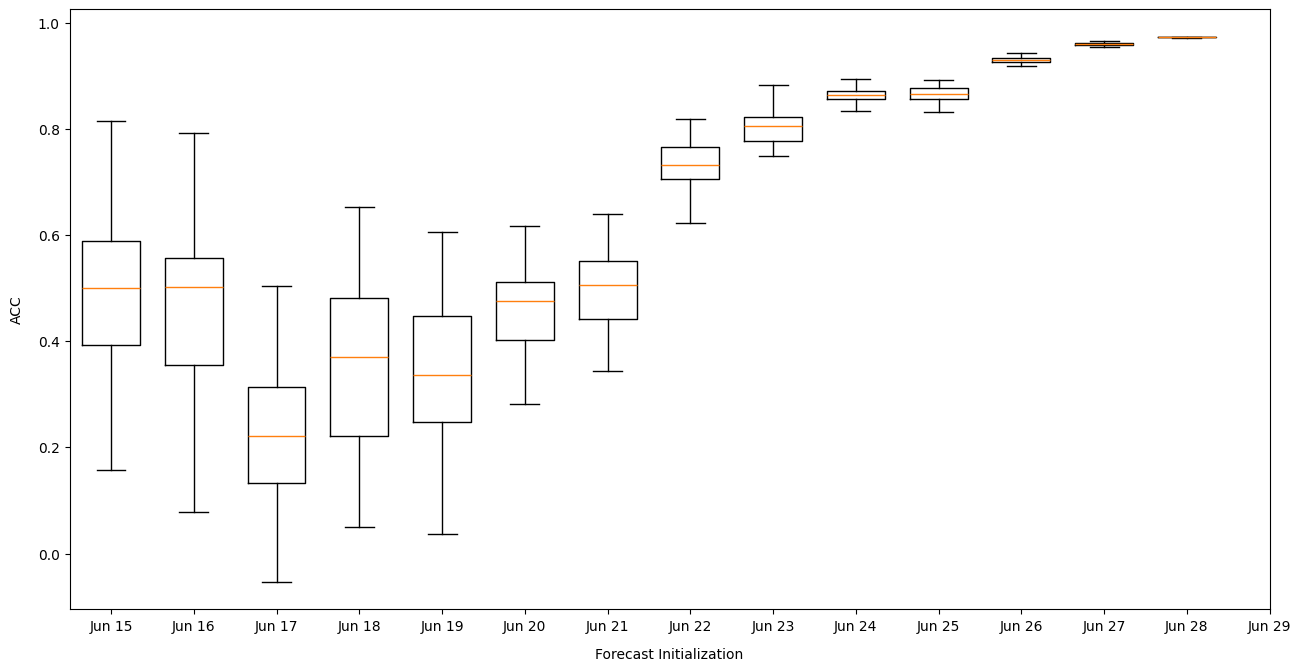

In [22]:
def plot_acc_boxplot(data):
    """
    Plot a bigger boxplot.

    Parameters:
    - data: The data for the boxplot.
    - labels: The labels for the x-axis ticks.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - title: The title of the plot (optional).

    Returns:
    - None (displays the plot).
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.set_xlabel("Forecast Initialization", labelpad=10)
    ax.set_ylabel("ACC", labelpad=10)

    
    ax.boxplot(data, showfliers=False, widths=0.7)

    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15],
           ["Jun 15", "Jun 16", "Jun 17", "Jun 18", "Jun 19", "Jun 20", "Jun 21","Jun 22", "Jun 23", "Jun 24", "Jun 25", "Jun 26", "Jun 27", 
               "Jun 28", "Jun 29"])
    plt.show()

#use this a this simple check before you create larger plot
plot_acc_boxplot(acc_fcnv2_era_z500_0629_ens_big.T)

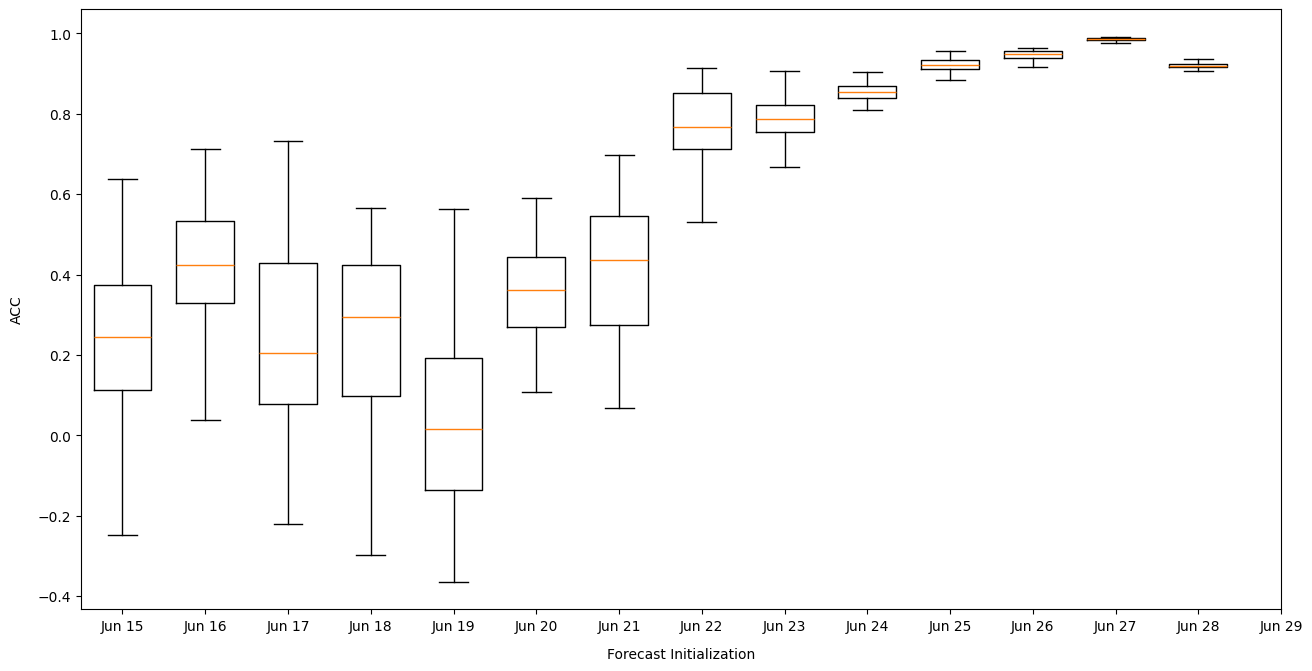

In [24]:
plot_acc_boxplot(acc_fcnv2_ec_z500_0629_ens_big.T)

In [5]:
%store -r acc_ec_z500_box_0629
%store -r acc_ec_z500_big_0629 
%store -r acc_ec_z500_whole_0629 
%store -r acc_ec_z500_box_0629_ens 
%store -r acc_ec_z500_big_0629_ens 
%store -r acc_ec_z500_whole_0629_ens






%store -r acc_fcnv1_ec_z500_box_0629 
%store -r acc_fcnv1_ec_z500_big_0629 
%store -r acc_fcnv1_ec_z500_whole_0629
%store -r acc_fcnv1_ec_z500_box_0629_ens 
%store -r acc_fcnv1_ec_z500_big_0629_ens 
%store -r acc_fcnv1_ec_z500_whole_0629_ens 



%store -r acc_fcnv1_era_z500_box_0629 
%store -r acc_fcnv1_era_z500_big_0629 
%store -r acc_fcnv1_era_z500_whole_0629 
%store -r acc_fcnv1_era_z500_box_0629_ens 
%store -r acc_fcnv1_era_z500_big_0629_ens 
%store -r acc_fcnv1_era_z500_whole_0629_ens 


%store -r acc_fcnv2_ec_z500_0629_ens_big
%store  -r acc_fcnv2_era_z500_0629_ens_big
%store  -r acc_fcnv2_ec_z500_0629_big
%store  -r acc_fcnv2_era_z500_0629_big

In [9]:
%store -r acc_fcnv2_era_z500_0629_big_weighted
%store -r acc_fcnv2_ec_z500_0629_big_weighted
%store -r acc_fcnv2_era_z500_0629_ens_big_weighted
%store -r acc_fcnv2_ec_z500_0629_ens_big_weighted

%store -r acc_ec_z500_box_0629_weighted
%store -r acc_ec_z500_big_0629_weighted
%store -r acc_ec_z500_whole_0629_weighted
%store -r acc_ec_z500_box_0629_ens_weighted
%store -r acc_ec_z500_big_0629_ens_weighted
%store -r acc_ec_z500_whole_0629_ens_weighted

%store -r acc_fcnv1_ec_z500_box_0629_weighted 
%store -r acc_fcnv1_ec_z500_big_0629_weighted 
%store -r acc_fcnv1_ec_z500_whole_0629_weighted
%store -r acc_fcnv1_ec_z500_box_0629_ens_weighted 
%store -r acc_fcnv1_ec_z500_big_0629_ens_weighted 
%store -r acc_fcnv1_ec_z500_whole_0629_ens_weighted 

%store -r acc_fcnv1_era_z500_box_0629_weighted  
%store -r acc_fcnv1_era_z500_big_0629_weighted  
%store -r acc_fcnv1_era_z500_whole_0629_weighted  
%store -r acc_fcnv1_era_z500_box_0629_ens_weighted  
%store -r acc_fcnv1_era_z500_big_0629_ens_weighted  
%store -r acc_fcnv1_era_z500_whole_0629_ens_weighted  

%store -r acc_pangu_z500_0629_big

In [21]:
plot_acc_boxplot(acc_ec_z500_big_0629_ens.T)

NameError: name 'plot_acc_boxplot' is not defined

In [32]:
np.shape(acc_fcnv2_ec_z500_0629_ens_big)

(14, 50)

In [29]:
np.shape(acc_fcnv2_era_z500_0629_big)

(15,)

-0.5
[[-0.04071428571428571, 0.38785714285714284, 0.8164285714285714, 1.2449999999999999, 1.6735714285714285, 2.102142857142857, 2.5307142857142852, 2.959285714285714, 3.3878571428571425, 3.816428571428571, 4.245, 4.673571428571429, 5.102142857142857, 5.530714285714286]]
0.5
[[-0.04071428571428571, 0.38785714285714284, 0.8164285714285714, 1.2449999999999999, 1.6735714285714285, 2.102142857142857, 2.5307142857142852, 2.959285714285714, 3.3878571428571425, 3.816428571428571, 4.245, 4.673571428571429, 5.102142857142857, 5.530714285714286], [0.04071428571428571, 0.46928571428571425, 0.8978571428571428, 1.3264285714285713, 1.755, 2.1835714285714287, 2.612142857142857, 3.040714285714286, 3.4692857142857143, 3.8978571428571427, 4.326428571428571, 4.755, 5.183571428571428, 5.612142857142857]]
-0.5
0.5
1.5


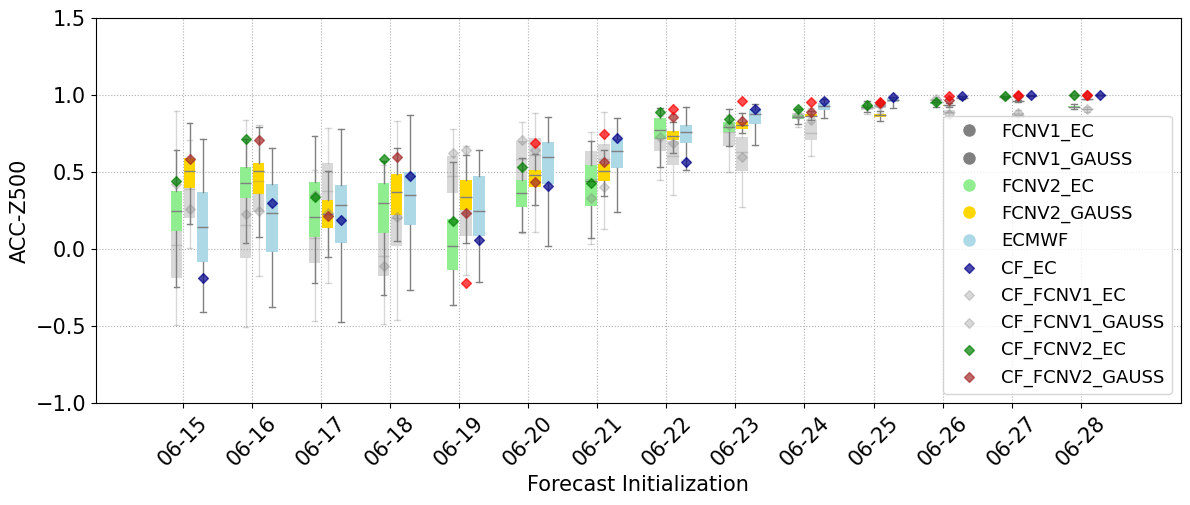

In [244]:
fig = plt.figure(figsize=(14, 5)) 

colors = ['grey','grey','lightgreen','gold','lightblue']
data_groups = [acc_fcnv1_ec_z500_big_0629_ens[0:14,:].T,acc_fcnv1_era_z500_big_0629_ens[0:14,:].T,acc_fcnv2_ec_z500_0629_ens_big.T,acc_fcnv2_era_z500_0629_ens_big.T,acc_ec_z500_big_0629_ens[0:14,:].T]


# --- Labels for your data:
labels_list = ['06-15','06-16','06-17','06-18','06-19','06-20','06-21','06-22','06-23','06-24','06-25','06-26','06-27','06-28']
width       = 1/len(labels_list)
width

xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(acc_ec_z500_big_0629_ens[0:14,:])) ]
xlocations

#symbol      = 'r+'
#ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
#ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
#ymax 

ax = plt.gca()
ax.set_ylim(-1,1.5) #do this becasue of the outlier problems

ax.grid(True, linestyle='dotted')
ax.set_axisbelow(True)

plt.xlabel('Forecast Initialization')
plt.ylabel('ACC-Z500')
#pl.title('title')

space = len(data_groups[2:5])/3
offset = len(data_groups[2:5])/3


# --- Offset the positions per group:

group_positions = []
for num, dg in enumerate(data_groups[0:2]):    
    _off = (0 - space + (0.5+num))
    print(_off)
    group_positions.append([x+_off*(width+0.01) for x in xlocations])
    print(group_positions)




for dg, pos, c in zip(data_groups[0:2], group_positions, colors[0:2]):
    boxes = ax.boxplot(dg, 
                #sym=symbol,
                labels=['']*len(labels_list),
    #            labels=labels_list,
                positions=pos, 
                widths=width, 
                boxprops=dict(facecolor=c,linewidth=0, edgecolor='grey',alpha=0.3),
    #             capprops=dict(color=c),
               whiskerprops=dict(color='grey',linewidth=1,alpha=0.3),
    #            flierprops=dict(color=c, markeredgecolor=c),                       
                medianprops=dict(color='grey',alpha=0.3),showfliers=False,
                capprops = dict(color='grey',linewidth=1,alpha=0.3),
    #           notch=False,  
    #           vert=True, 
    #           whis=1.5,
    #           bootstrap=None, 
    #           usermedians=None, 
    #           conf_intervals=None,
                patch_artist=True, 
                )


space = len(data_groups[2:5])/3
offset = len(data_groups[2:5])/3

group_positions = []
for num, dg in enumerate(data_groups[2:5]):    
    _off = (0 - space + (0.5+num))
    print(_off)
    group_positions.append([x+_off*(width+0.01) for x in xlocations])




for dg, pos, c in zip(data_groups[2:5], group_positions, colors[2:5]):
    boxes = ax.boxplot(dg, 
               # sym=symbol,
                labels=['']*len(labels_list),
    #            labels=labels_list,
                positions=pos, 
                widths=width, 
                boxprops=dict(facecolor=c,linewidth=0, edgecolor='grey'),
    #             capprops=dict(color=c),
               whiskerprops=dict(color='grey',linewidth=1),
    #            flierprops=dict(color=c, markeredgecolor=c),                       
                medianprops=dict(color='grey'),showfliers=False,
                capprops = dict(color='grey',linewidth=1),
    #           notch=False,  
    #           vert=True, 
    #           whis=1.5,
    #           bootstrap=None, 
    #           usermedians=None, 
    #           conf_intervals=None,
                patch_artist=True, 
                )

%store -r mean_era5_06_29
#line_artists = []
#line = plt.axhline(y=ds_era5_t850_box_0629_mean , color='r', linestyle='-',label = 'ERA5')
#line_artists.append(line)


ax.set_xticks( xlocations )
ax.set_xticklabels( labels_list, rotation=45 )
#add the control forecast

point_artists = []
points_1 = ax.scatter(group_positions[2],acc_ec_z500_big_0629[0:14],color='darkblue',marker='D',zorder = 5,s =25,alpha=0.7,label = 'CF_EC')
points_2 = ax.scatter(group_positions[0],acc_fcnv1_ec_z500_big_0629[0:14],color='grey',marker='D',zorder = 5,s =25,alpha=0.3,label = 'CF_FCNV1_EC')
points_3 = ax.scatter(group_positions[1],acc_fcnv1_era_z500_big_0629[0:14],color='grey',marker='D',zorder = 5,s =25,alpha=0.3,label = 'CF_FCNV1_GAUSS')
points_4 = ax.scatter(group_positions[0],acc_fcnv2_ec_z500_0629_big[1:15],color='green',marker='D',zorder = 5,s =25,alpha=0.7,label = 'CF_FCNV2_EC')
points_5 = ax.scatter(group_positions[1],acc_fcnv2_era_z500_0629_big[1:15],color='brown',marker='D',zorder = 5,s =25,alpha=0.7,label = 'CF_FCNV2_GAUSS')
points_6 = ax.scatter(group_positions[1][4:15],acc_pangu_z500_0629_big,color='red',marker='D',zorder = 5,s =25,alpha=0.7,label = 'Pangu')

point_artists.append(points_1)
point_artists.append(points_2)
point_artists.append(points_3)
point_artists.append(points_4)
point_artists.append(points_5)



legend_labels = ['FCNV1_EC','FCNV1_GAUSS','FCNV2_EC','FCNV2_GAUSS','ECMWF','ERA5']
legend_handles = [plt.Line2D([0], [0],marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(legend_labels[:5], colors)] + point_artists 
plt.legend(handles=legend_handles, loc='lower right')
#plt.savefig('/home/kit/imk-tro/gj5173/30.01_stroryline/z500-ACC_box_v1_v2_bw.png', bbox_inches='tight',dpi=200)

plt.show()

-0.5
[[-0.04071428571428571, 0.38785714285714284, 0.8164285714285714, 1.2449999999999999, 1.6735714285714285, 2.102142857142857, 2.5307142857142852, 2.959285714285714, 3.3878571428571425, 3.816428571428571, 4.245, 4.673571428571429, 5.102142857142857, 5.530714285714286]]
0.5
[[-0.04071428571428571, 0.38785714285714284, 0.8164285714285714, 1.2449999999999999, 1.6735714285714285, 2.102142857142857, 2.5307142857142852, 2.959285714285714, 3.3878571428571425, 3.816428571428571, 4.245, 4.673571428571429, 5.102142857142857, 5.530714285714286], [0.04071428571428571, 0.46928571428571425, 0.8978571428571428, 1.3264285714285713, 1.755, 2.1835714285714287, 2.612142857142857, 3.040714285714286, 3.4692857142857143, 3.8978571428571427, 4.326428571428571, 4.755, 5.183571428571428, 5.612142857142857]]
-0.5
0.5
1.5


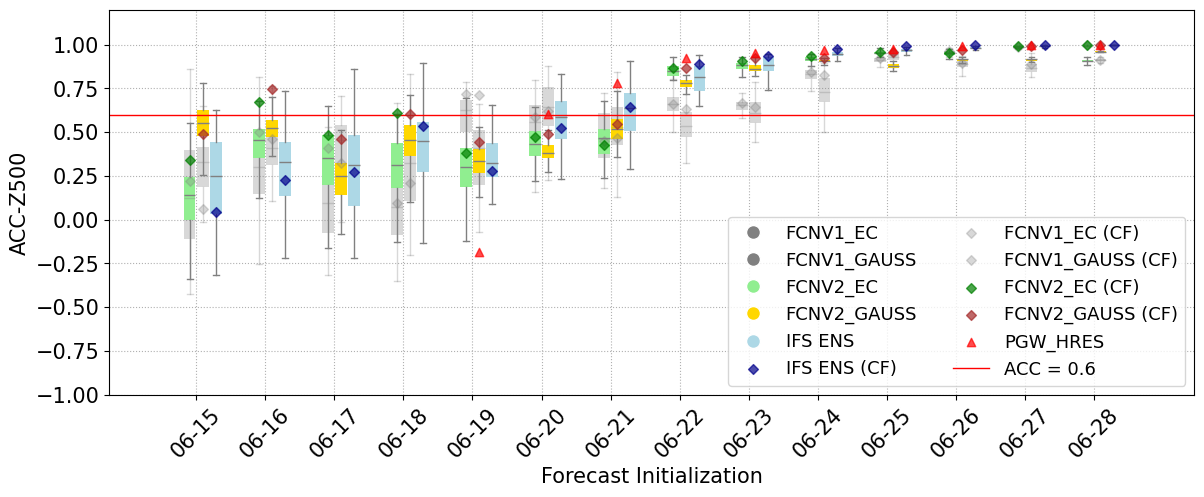

In [11]:
fig = plt.figure(figsize=(14, 5)) 

colors = ['grey','grey','lightgreen','gold','lightblue']
data_groups = [acc_fcnv1_ec_z500_big_0629_ens_weighted [0:14,:].T,acc_fcnv1_era_z500_big_0629_ens_weighted [0:14,:].T,acc_fcnv2_ec_z500_0629_ens_big_weighted .T,acc_fcnv2_era_z500_0629_ens_big_weighted .T,acc_ec_z500_big_0629_ens_weighted [0:14,:].T]


# --- Labels for your data:
labels_list = ['06-15','06-16','06-17','06-18','06-19','06-20','06-21','06-22','06-23','06-24','06-25','06-26','06-27','06-28']
width       = 1/len(labels_list)
width

xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(acc_ec_z500_big_0629_ens_weighted[0:14,:])) ]
xlocations

#symbol      = 'r+'
#ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
#ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
#ymax 

ax = plt.gca()
ax.set_ylim(-1,1.2) #do this becasue of the outlier problems

ax.grid(True, linestyle='dotted')
ax.set_axisbelow(True)

plt.xlabel('Forecast Initialization')
plt.ylabel('ACC-Z500')
#pl.title('title')

space = len(data_groups[2:5])/3
offset = len(data_groups[2:5])/3


# --- Offset the positions per group:

group_positions = []
for num, dg in enumerate(data_groups[0:2]):    
    _off = (0 - space + (0.5+num))
    print(_off)
    group_positions.append([x+_off*(width+0.01) for x in xlocations])
    print(group_positions)




for dg, pos, c in zip(data_groups[0:2], group_positions, colors[0:2]):
    boxes = ax.boxplot(dg, 
                #sym=symbol,
                labels=['']*len(labels_list),
    #            labels=labels_list,
                positions=pos, 
                widths=width, 
                boxprops=dict(facecolor=c,linewidth=0, edgecolor='grey',alpha=0.3),
    #             capprops=dict(color=c),
               whiskerprops=dict(color='grey',linewidth=1,alpha=0.3),
    #            flierprops=dict(color=c, markeredgecolor=c),                       
                medianprops=dict(color='grey',alpha=0.3),showfliers=False,
                capprops = dict(color='grey',linewidth=1,alpha=0.3),
    #           notch=False,  
    #           vert=True, 
    #           whis=1.5,
    #           bootstrap=None, 
    #           usermedians=None, 
    #           conf_intervals=None,
                patch_artist=True, 
                )


space = len(data_groups[2:5])/3
offset = len(data_groups[2:5])/3

group_positions = []
for num, dg in enumerate(data_groups[2:5]):    
    _off = (0 - space + (0.5+num))
    print(_off)
    group_positions.append([x+_off*(width+0.01) for x in xlocations])




for dg, pos, c in zip(data_groups[2:5], group_positions, colors[2:5]):
    boxes = ax.boxplot(dg, 
               # sym=symbol,
                labels=['']*len(labels_list),
    #            labels=labels_list,
                positions=pos, 
                widths=width, 
                boxprops=dict(facecolor=c,linewidth=0, edgecolor='grey'),
    #             capprops=dict(color=c),
               whiskerprops=dict(color='grey',linewidth=1),
    #            flierprops=dict(color=c, markeredgecolor=c),                       
                medianprops=dict(color='grey'),showfliers=False,
                capprops = dict(color='grey',linewidth=1),
    #           notch=False,  
    #           vert=True, 
    #           whis=1.5,
    #           bootstrap=None, 
    #           usermedians=None, 
    #           conf_intervals=None,
                patch_artist=True, 
                )

%store -r mean_era5_06_29
line_artists = []
line = plt.axhline(y=0.6 , color='red', linestyle='-',linewidth = 1,label = 'ACC = 0.6')
line_artists.append(line)


ax.set_xticks( xlocations )
ax.set_xticklabels( labels_list, rotation=45 )
#add the control forecast

point_artists = []
points_1 = ax.scatter(group_positions[2],acc_ec_z500_big_0629_weighted [0:14],color='darkblue',marker='D',zorder = 5,s =25,alpha=0.7,label = 'IFS ENS (CF)')
points_2 = ax.scatter(group_positions[0],acc_fcnv1_ec_z500_big_0629_weighted [0:14],color='grey',marker='D',zorder = 5,s =25,alpha=0.3,label = 'FCNV1_EC (CF)')
points_3 = ax.scatter(group_positions[1],acc_fcnv1_era_z500_big_0629_weighted [0:14],color='grey',marker='D',zorder = 5,s =25,alpha=0.3,label = 'FCNV1_GAUSS (CF)')
points_4 = ax.scatter(group_positions[0],acc_fcnv2_ec_z500_0629_big_weighted [1:15],color='green',marker='D',zorder = 5,s =25,alpha=0.7,label = 'FCNV2_EC (CF)')
points_5 = ax.scatter(group_positions[1],acc_fcnv2_era_z500_0629_big_weighted [1:15],color='brown',marker='D',zorder = 5,s =25,alpha=0.7,label = 'FCNV2_GAUSS (CF)')
points_6 = ax.scatter(group_positions[1][4:15],acc_pangu_z500_0629_big,color='red',marker='^',zorder = 5,alpha=0.7,label = 'PGW_HRES')
point_artists.append(points_1)
point_artists.append(points_2)
point_artists.append(points_3)
point_artists.append(points_4)
point_artists.append(points_5)
point_artists.append(points_6)


legend_labels = ['FCNV1_EC','FCNV1_GAUSS','FCNV2_EC','FCNV2_GAUSS','IFS ENS']
legend_handles = [plt.Line2D([0], [0],marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(legend_labels[:5], colors)] + point_artists + line_artists 

plt.legend(handles=legend_handles, loc='lower right',ncol=2)
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/forecast_evolution_z500.png', bbox_inches='tight',dpi=200)

plt.show()

array([0.34021368, 0.67104541, 0.48073291, 0.6113139 , 0.38339441,
       0.47448756, 0.42857488, 0.8659781 , 0.90519427, 0.93589851,
       0.95843396, 0.95465312, 0.99180134, 0.99720405])

In [ ]:
#################################################### line plot #####################################################################################################

In [14]:
def calculate_stats_as_xarray(data):
    mean_values = [np.mean(data[i, :]) for i in range(14)]
    median_values = [statistics.median(data[i, :]) for i in range(14)]
    std_dev_values = [np.std(data[i, :]) for i in range(14)]
    
    mean_da = xr.DataArray(mean_values, dims='member', name='mean')
    median_da = xr.DataArray(median_values, dims='member', name='median')
    std_dev_da = xr.DataArray(std_dev_values, dims='member', name='std_dev')
    
    return mean_da, median_da, std_dev_da

In [255]:
ds_mean_ec_ens_box, ds_median_ec_ens_box, ds_std_dev_ec_ens_box = calculate_stats_as_xarray(acc_ec_z500_big_0629_ens[0:14,:])

ds_mean_fcnv1_ec_ens_box, ds_median_fcnv1_ec_ens_box, ds_std_dev_fcnv1_ec_ens_box = calculate_stats_as_xarray(acc_fcnv1_ec_z500_big_0629_ens[0:14,:])

ds_mean_fcnv1_era_ens_box, ds_median_fcnv1_era_ens_box, ds_std_dev_fcnv1_era_ens_box = calculate_stats_as_xarray(acc_fcnv1_era_z500_big_0629_ens[0:14,:])

ds_mean_fcnv2_ec_ens_box, ds_median_fcnv2_ec_ens_box, ds_std_dev_fcnv2_ec_ens_box = calculate_stats_as_xarray(acc_fcnv2_ec_z500_0629_ens_big)

ds_mean_fcnv2_era_ens_box, ds_median_fcnv2_era_ens_box, ds_std_dev_fcnv2_era_ens_box = calculate_stats_as_xarray(acc_fcnv2_era_z500_0629_ens_big)

In [19]:
ds_mean_ec_ens_box_weighted, ds_median_ec_ens_box_weighted, ds_std_dev_ec_ens_box_weighted = calculate_stats_as_xarray(acc_ec_z500_big_0629_ens_weighted[0:14,:])

ds_mean_fcnv1_ec_ens_box_weighted, ds_median_fcnv1_ec_ens_box_weighted, ds_std_dev_fcnv1_ec_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv1_ec_z500_big_0629_ens_weighted[0:14,:])

ds_mean_fcnv1_era_ens_box_weighted, ds_median_fcnv1_era_ens_box_weighted, ds_std_dev_fcnv1_era_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv1_era_z500_big_0629_ens_weighted[0:14,:])

ds_mean_fcnv2_ec_ens_box_weighted, ds_median_fcnv2_ec_ens_box_weighted, ds_std_dev_fcnv2_ec_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv2_ec_z500_0629_ens_big_weighted)

ds_mean_fcnv2_era_ens_box_weighted, ds_median_fcnv2_era_ens_box_weighted, ds_std_dev_fcnv2_era_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv2_era_z500_0629_ens_big_weighted)

In [257]:
data_groups = [acc_fcnv1_ec_z500_big_0629_ens[0:14,:].T,acc_fcnv1_era_z500_big_0629_ens[0:14,:].T,acc_fcnv2_ec_z500_0629_ens_big.T,acc_fcnv2_era_z500_0629_ens_big.T,acc_ec_z500_big_0629_ens[0:14,:].T]

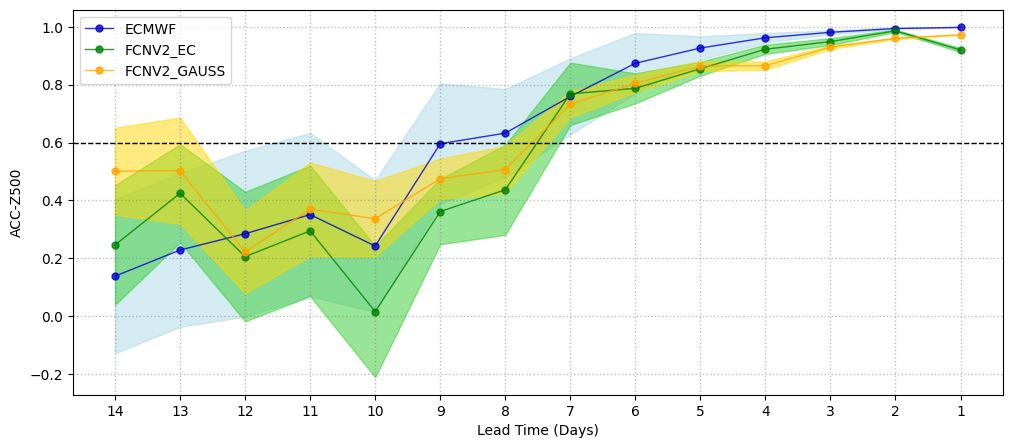

In [7]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()

x = np.linspace(0, 13, 14)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, ds_median_ec_ens_box,marker='o',label='ECMWF',linewidth=1,markersize= 5,color = 'mediumblue',alpha=0.8);
ax.fill_between(x, ds_median_ec_ens_box - ds_std_dev_ec_ens_box, ds_median_ec_ens_box + ds_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax.plot(x, ds_median_fcnv2_ec_ens_box[:],marker='o',label='FCNV2_EC',linewidth=1,markersize= 5,color = 'green',alpha=0.8);
ax.fill_between(x, ds_median_fcnv2_ec_ens_box - ds_std_dev_fcnv2_ec_ens_box, ds_median_fcnv2_ec_ens_box + ds_std_dev_fcnv2_ec_ens_box, color='limegreen', alpha=0.5)
ax.plot(x, ds_median_fcnv2_era_ens_box[:],marker='o',label='FCNV2_GAUSS',linewidth=1,markersize= 5,color = 'orange',alpha=0.8);
ax.fill_between(x, ds_median_fcnv2_era_ens_box - ds_std_dev_fcnv2_era_ens_box, ds_median_fcnv2_era_ens_box + ds_std_dev_fcnv2_era_ens_box, color='gold', alpha=0.5)
#ax.plot(x, acc_fcnv1_ec_z500_big_0629,marker='o',label='FCN_EC_CF',color = 'limegreen');
#ax.scatter(x, acc_ec_z500_big_0629,marker='o',label='ECMWF_CF',linewidth=1,color = 'mediumblue');
#ax.scatter(x, acc_fcnv1_era_z500_big_0629,marker='o',label='FCN_ERA_CF',color='darkorange');
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imk-tro/gj5173/result_0415/line_plot_0629_z500_ACC_FCNV2.png', bbox_inches='tight',dpi=200)

In [258]:
data_groups_weighted = [acc_fcnv1_ec_z500_big_0629_ens_weighted[0:14,:].T,acc_fcnv1_era_z500_big_0629_ens_weighted[0:14,:].T,acc_fcnv2_ec_z500_0629_ens_big_weighted.T,acc_fcnv2_era_z500_0629_ens_big_weighted.T,acc_ec_z500_big_0629_ens_weighted[0:14,:].T]

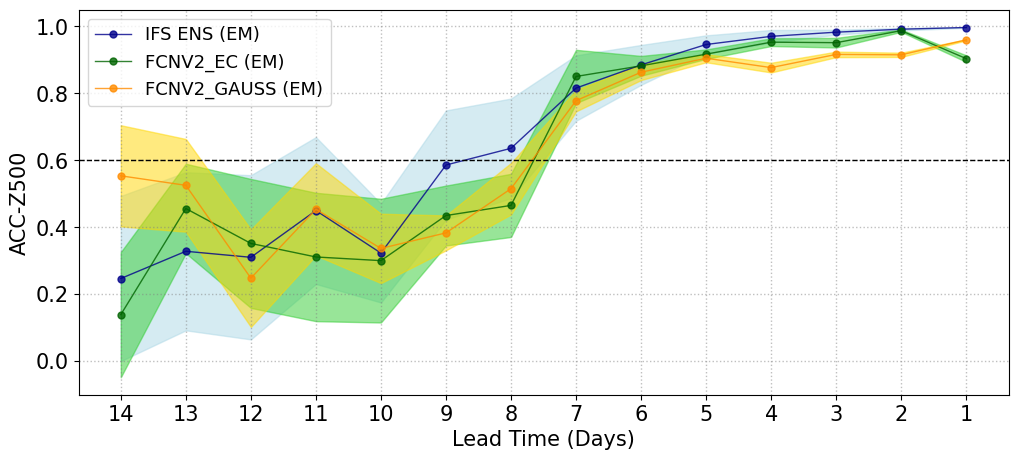

In [264]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()

x = np.linspace(0, 13, 14)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, ds_median_ec_ens_box_weighted,marker='o',label='IFS ENS (EM)',linewidth=1,markersize= 5,color = 'darkblue',alpha=0.8);
ax.fill_between(x, ds_median_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_median_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
ax.plot(x, ds_median_fcnv2_ec_ens_box_weighted[:],marker='o',label='FCNV2_EC (EM)',linewidth=1,markersize= 5,color = 'darkgreen',alpha=0.8);
ax.fill_between(x, ds_median_fcnv2_ec_ens_box_weighted - ds_std_dev_fcnv2_ec_ens_box_weighted, ds_median_fcnv2_ec_ens_box_weighted + ds_std_dev_fcnv2_ec_ens_box_weighted, color='limegreen', alpha=0.5)
ax.plot(x, ds_median_fcnv2_era_ens_box_weighted[:],marker='o',label='FCNV2_GAUSS (EM)',linewidth=1,markersize= 5,color = 'darkorange',alpha=0.8);
ax.fill_between(x, ds_median_fcnv2_era_ens_box_weighted - ds_std_dev_fcnv2_era_ens_box_weighted, ds_median_fcnv2_era_ens_box_weighted + ds_std_dev_fcnv2_era_ens_box_weighted, color='gold', alpha=0.5)
#ax.plot(x, acc_fcnv1_ec_z500_big_0629,marker='o',label='FCN_EC_CF',color = 'limegreen');
#ax.scatter(x, acc_ec_z500_big_0629,marker='o',label='ECMWF_CF',linewidth=1,color = 'mediumblue');
#ax.scatter(x, acc_fcnv1_era_z500_big_0629,marker='o',label='FCN_ERA_CF',color='darkorange');
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/line_plot_0629_z500_ACC_FCNV2_weighted.png', bbox_inches='tight',dpi=200)

In [470]:
ds_mean_ec_ens_box_weighted

<xarray.DataArray 'mean' (member: 14)> Size: 112B
array([0.21900147, 0.29363972, 0.28905011, 0.39976757, 0.34860033,
       0.55401137, 0.61080064, 0.8025019 , 0.87549167, 0.94240299,
       0.96440673, 0.98114436, 0.99081709, 0.99689708])
Dimensions without coordinates: member

In [20]:
ds_mean_ec_ens_box_weighted

<xarray.DataArray 'mean' (member: 14)> Size: 112B
array([0.21900147, 0.29363972, 0.28905011, 0.39976757, 0.34860033,
       0.55401137, 0.61080064, 0.8025019 , 0.87549167, 0.94240299,
       0.96440673, 0.98114436, 0.99081709, 0.99689708])
Dimensions without coordinates: member

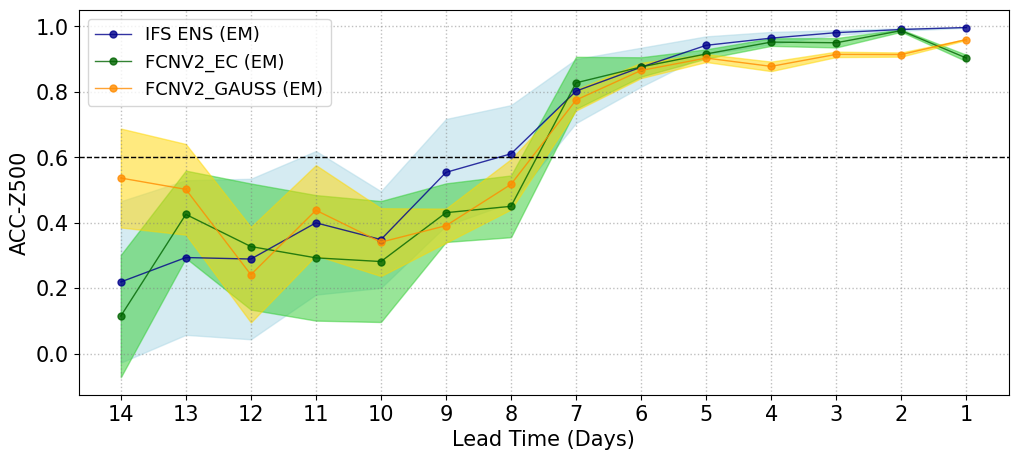

In [23]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()

x = np.linspace(0, 13, 14)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, ds_mean_ec_ens_box_weighted,marker='o',label='IFS ENS (EM)',linewidth=1,markersize= 5,color = 'darkblue',alpha=0.8);
ax.fill_between(x, ds_mean_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_mean_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
ax.plot(x, ds_mean_fcnv2_ec_ens_box_weighted[:],marker='o',label='FCNV2_EC (EM)',linewidth=1,markersize= 5,color = 'darkgreen',alpha=0.8);
ax.fill_between(x, ds_mean_fcnv2_ec_ens_box_weighted - ds_std_dev_fcnv2_ec_ens_box_weighted, ds_mean_fcnv2_ec_ens_box_weighted + ds_std_dev_fcnv2_ec_ens_box_weighted, color='limegreen', alpha=0.5)
ax.plot(x, ds_mean_fcnv2_era_ens_box_weighted[:],marker='o',label='FCNV2_GAUSS (EM)',linewidth=1,markersize= 5,color = 'darkorange',alpha=0.8);
ax.fill_between(x, ds_mean_fcnv2_era_ens_box_weighted - ds_std_dev_fcnv2_era_ens_box_weighted, ds_mean_fcnv2_era_ens_box_weighted + ds_std_dev_fcnv2_era_ens_box_weighted, color='gold', alpha=0.5)
#ax.plot(x, acc_fcnv1_ec_z500_big_0629,marker='o',label='FCN_EC_CF',color = 'limegreen');
#ax.scatter(x, acc_ec_z500_big_0629,marker='o',label='ECMWF_CF',linewidth=1,color = 'mediumblue');
#ax.scatter(x, acc_fcnv1_era_z500_big_0629,marker='o',label='FCN_ERA_CF',color='darkorange');
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_line_z500_fcnv2.png', bbox_inches='tight',dpi=200)

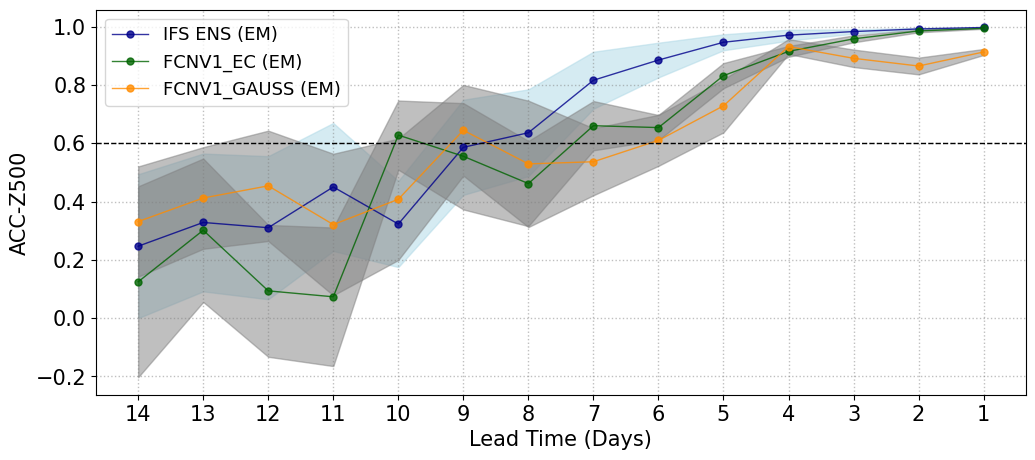

In [268]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()

x = np.linspace(0, 13, 14)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, ds_median_ec_ens_box_weighted,marker='o',label='IFS ENS (EM)',linewidth=1,markersize= 5,color = 'darkblue',alpha=0.8);
ax.fill_between(x, ds_median_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_median_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
ax.plot(x, ds_median_fcnv1_ec_ens_box_weighted[:],marker='o',label='FCNV1_EC (EM)',linewidth=1,markersize= 5,color = 'darkgreen',alpha=0.8);
ax.fill_between(x, ds_median_fcnv1_ec_ens_box_weighted - ds_std_dev_fcnv1_ec_ens_box_weighted, ds_median_fcnv1_ec_ens_box_weighted + ds_std_dev_fcnv1_ec_ens_box_weighted, color='grey', alpha=0.5)
ax.plot(x, ds_median_fcnv1_era_ens_box_weighted[:],marker='o',label='FCNV1_GAUSS (EM)',linewidth=1,markersize= 5,color = 'darkorange',alpha=0.8);
ax.fill_between(x, ds_median_fcnv1_era_ens_box_weighted - ds_std_dev_fcnv1_era_ens_box_weighted, ds_median_fcnv1_era_ens_box_weighted + ds_std_dev_fcnv1_era_ens_box_weighted, color='grey', alpha=0.5)
#ax.plot(x, acc_fcnv1_ec_z500_big_0629,marker='o',label='FCN_EC_CF',color = 'limegreen');
#ax.scatter(x, acc_ec_z500_big_0629,marker='o',label='ECMWF_CF',linewidth=1,color = 'mediumblue');
#ax.scatter(x, acc_fcnv1_era_z500_big_0629,marker='o',label='FCN_ERA_CF',color='darkorange');
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/line_plot_0629_z500_ACC_FCNV2_weighted.png', bbox_inches='tight',dpi=200)

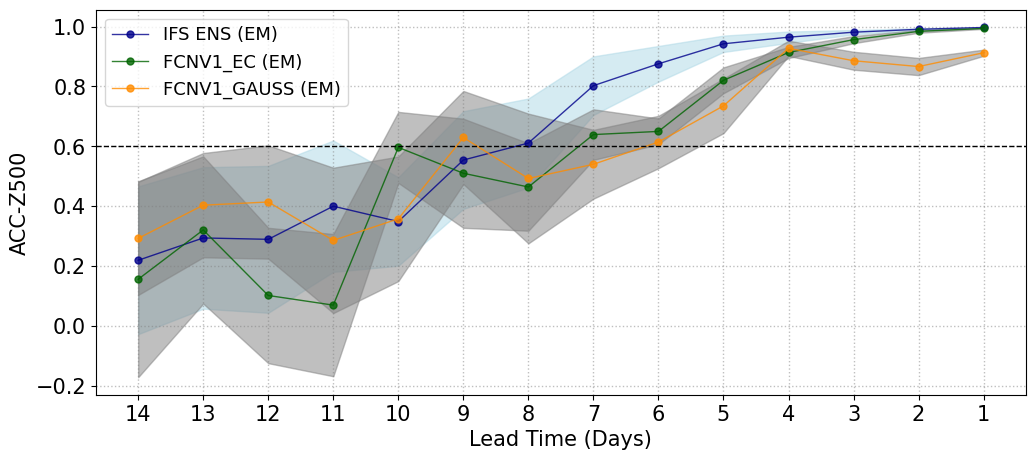

In [24]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()

x = np.linspace(0, 13, 14)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, ds_mean_ec_ens_box_weighted,marker='o',label='IFS ENS (EM)',linewidth=1,markersize= 5,color = 'darkblue',alpha=0.8);
ax.fill_between(x, ds_mean_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_mean_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
ax.plot(x, ds_mean_fcnv1_ec_ens_box_weighted[:],marker='o',label='FCNV1_EC (EM)',linewidth=1,markersize= 5,color = 'darkgreen',alpha=0.8);
ax.fill_between(x, ds_mean_fcnv1_ec_ens_box_weighted - ds_std_dev_fcnv1_ec_ens_box_weighted, ds_mean_fcnv1_ec_ens_box_weighted + ds_std_dev_fcnv1_ec_ens_box_weighted, color='grey', alpha=0.5)
ax.plot(x, ds_mean_fcnv1_era_ens_box_weighted[:],marker='o',label='FCNV1_GAUSS (EM)',linewidth=1,markersize= 5,color = 'darkorange',alpha=0.8);
ax.fill_between(x, ds_mean_fcnv1_era_ens_box_weighted - ds_std_dev_fcnv1_era_ens_box_weighted, ds_mean_fcnv1_era_ens_box_weighted + ds_std_dev_fcnv1_era_ens_box_weighted, color='grey', alpha=0.5)
#ax.plot(x, acc_fcnv1_ec_z500_big_0629,marker='o',label='FCN_EC_CF',color = 'limegreen');
#ax.scatter(x, acc_ec_z500_big_0629,marker='o',label='ECMWF_CF',linewidth=1,color = 'mediumblue');
#ax.scatter(x, acc_fcnv1_era_z500_big_0629,marker='o',label='FCN_ERA_CF',color='darkorange');
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_line_z500_fcnv1.png.png', bbox_inches='tight',dpi=200)

In [ ]:
acc_ec_z500_big_0629_weighted
acc_fcnv1_ec_z500_big_0629_weighted
acc_fcnv1_era_z500_big_0629_weighted
acc_fcnv2_ec_z500_0629_big_weighted
acc_fcnv2_era_z500_0629_big_weighted
acc_pangu_z500_0629_big

In [30]:
np.shape(acc_ec_z500_big_0629_weighted)

(15,)

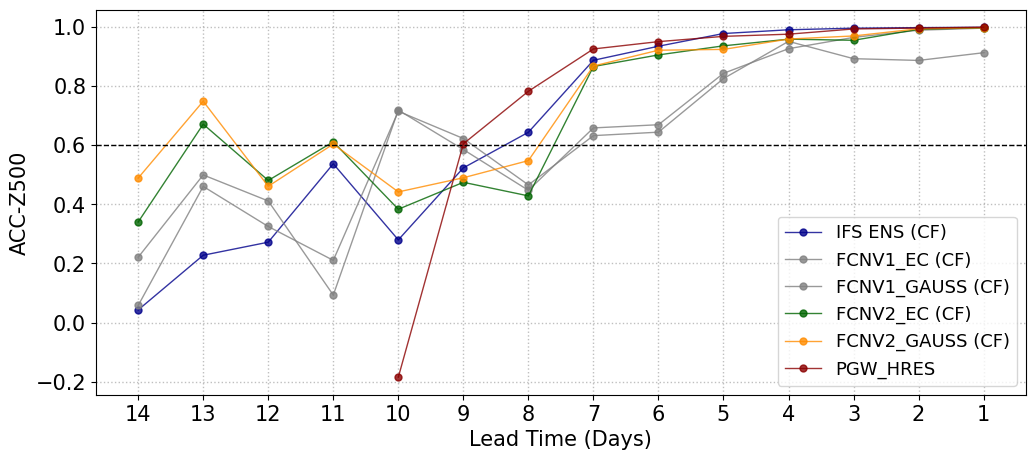

In [32]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()

x = np.linspace(0, 13, 14)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, acc_ec_z500_big_0629_weighted[0:14],marker='o',label='IFS ENS (CF)',linewidth=1,markersize= 5,color = 'darkblue',alpha=0.8);
#ax.fill_between(x, ds_mean_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_mean_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
ax.plot(x, acc_fcnv1_ec_z500_big_0629_weighted[0:14],marker='o',label='FCNV1_EC (CF)',linewidth=1,markersize= 5,color = 'grey',alpha=0.8);
#ax.fill_between(x, ds_mean_fcnv1_ec_ens_box_weighted - ds_std_dev_fcnv1_ec_ens_box_weighted, ds_mean_fcnv1_ec_ens_box_weighted + ds_std_dev_fcnv1_ec_ens_box_weighted, color='grey', alpha=0.5)
ax.plot(x, acc_fcnv1_era_z500_big_0629_weighted[0:14],marker='o',label='FCNV1_GAUSS (CF)',linewidth=1,markersize= 5,color = 'grey',alpha=0.8);
ax.plot(x, acc_fcnv2_ec_z500_0629_big_weighted[1:15],marker='o',label='FCNV2_EC (CF)',linewidth=1,markersize= 5,color = 'darkgreen',alpha=0.8);
ax.plot(x, acc_fcnv2_era_z500_0629_big_weighted[1:15],marker='o',label='FCNV2_GAUSS (CF)',linewidth=1,markersize= 5,color = 'darkorange',alpha=0.8);
ax.plot(x[4:14], acc_pangu_z500_0629_big,marker='o',label='PGW_HRES',linewidth=1,markersize= 5,color = 'darkred',alpha=0.8);
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_line_plot_0629_z500_ACC_cf.png', bbox_inches='tight',dpi=200)

In [ ]:
############################ extract forecast skill horizon ###########################################################################

In [272]:
def calculate_stats_as_xarray(data):
    mean_values = [np.mean(data[i, :]) for i in range(14)]
    median_values = [statistics.median(data[i, :]) for i in range(14)]
    std_dev_values = [np.std(data[i, :]) for i in range(14)]
    
    mean_da = xr.DataArray(mean_values, dims='member', name='mean')
    median_da = xr.DataArray(median_values, dims='member', name='median')
    std_dev_da = xr.DataArray(std_dev_values, dims='member', name='std_dev')
    
    return mean_da, median_da, std_dev_da

In [49]:
ds_mean_ec_ens_box_weighted, ds_median_ec_ens_box_weighted, ds_std_dev_ec_ens_box_weighted = calculate_stats_as_xarray(acc_ec_z500_big_0629_ens_weighted[0:14,:])

ds_mean_fcnv1_ec_ens_box_weighted, ds_median_fcnv1_ec_ens_box_weighted, ds_std_dev_fcnv1_ec_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv1_ec_z500_big_0629_ens_weighted[0:14,:])

ds_mean_fcnv1_era_ens_box_weighted, ds_median_fcnv1_era_ens_box_weighted, ds_std_dev_fcnv1_era_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv1_era_z500_big_0629_ens_weighted[0:14,:])

ds_mean_fcnv2_ec_ens_box_weighted, ds_median_fcnv2_ec_ens_box_weighted, ds_std_dev_fcnv2_ec_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv2_ec_z500_0629_ens_big_weighted)

ds_mean_fcnv2_era_ens_box_weighted, ds_median_fcnv2_era_ens_box_weighted, ds_std_dev_fcnv2_era_ens_box_weighted = calculate_stats_as_xarray(acc_fcnv2_era_z500_0629_ens_big_weighted)

In [ ]:
%store -r acc_fcnv2_era_z500_0629_big_weighted
%store -r acc_fcnv2_ec_z500_0629_big_weighted
%store -r acc_fcnv2_era_z500_0629_ens_big_weighted
%store -r acc_fcnv2_ec_z500_0629_ens_big_weighted

%store -r acc_ec_z500_box_0629_weighted
%store -r acc_ec_z500_big_0629_weighted
%store -r acc_ec_z500_whole_0629_weighted
%store -r acc_ec_z500_box_0629_ens_weighted
%store -r acc_ec_z500_big_0629_ens_weighted
%store -r acc_ec_z500_whole_0629_ens_weighted

%store -r acc_fcnv1_ec_z500_box_0629_weighted 
%store -r acc_fcnv1_ec_z500_big_0629_weighted 
%store -r acc_fcnv1_ec_z500_whole_0629_weighted
%store -r acc_fcnv1_ec_z500_box_0629_ens_weighted 
%store -r acc_fcnv1_ec_z500_big_0629_ens_weighted 
%store -r acc_fcnv1_ec_z500_whole_0629_ens_weighted 

%store -r acc_fcnv1_era_z500_box_0629_weighted  
%store -r acc_fcnv1_era_z500_big_0629_weighted  
%store -r acc_fcnv1_era_z500_whole_0629_weighted  
%store -r acc_fcnv1_era_z500_box_0629_ens_weighted  
%store -r acc_fcnv1_era_z500_big_0629_ens_weighted  
%store -r acc_fcnv1_era_z500_whole_0629_ens_weighted  

In [278]:
acc_ec_z500_big_0629_weighted

array([0.043012  , 0.22790515, 0.27199997, 0.53713966, 0.27979554,
       0.5232771 , 0.64365341, 0.88697405, 0.93457258, 0.9775396 ,
       0.99016798, 0.99556939, 0.99745605, 0.99865823, 0.99928022])

In [283]:
acc_ec_z500_big_0629_weighted
acc_fcnv1_ec_z500_big_0629_weighted
acc_fcnv1_era_z500_big_0629_weighted
acc_fcnv2_ec_z500_0629_big_weighted
acc_fcnv2_era_z500_0629_big_weighted
acc_pangu_z500_0629_big

array([-0.22506178,  0.68289795,  0.74678416,  0.90826468,  0.95986396,
        0.9523642 ,  0.95152367,  0.99312494,  0.99657766,  0.99924053])

In [60]:
import numpy as np
from scipy.interpolate import interp1d

def calculate_lead_time_z500(ds_median):
    lead_time = np.linspace(1, 14, 14)
    fine_lead_times = np.linspace(1, 14, 1000)
    
    interp_func = interp1d(lead_time, ds_median[::-1], kind='linear')
   
    interpolated_ds = interp_func(fine_lead_times)
    lead_time_index = np.argmax(interpolated_ds< 0.6)
    lead_time = fine_lead_times[lead_time_index]
    return lead_time

In [111]:
calculate_lead_time_z500([0,0,0,0,0,0,0,0.6,0.7,0.9,0.9,1,1,1])

7.012012012012012

In [ ]:
[0,0,0,0.6,0.7]

In [92]:
import numpy as np
from scipy.interpolate import interp1d

def calculate_lead_time_z500_pangu(ds_median):
    lead_time = np.linspace(1, 10, 10)
    fine_lead_times = np.linspace(1, 10, 1000)
    
    interp_func = interp1d(lead_time, ds_median[::-1], kind='linear')
   
    interpolated_ds = interp_func(fine_lead_times)
    lead_time_index = np.argmax(interpolated_ds< 0.6)
    lead_time = fine_lead_times[lead_time_index]
    return lead_time

In [43]:
np.shape(acc_fcnv2_ec_z500_0629_big_weighted)

(15,)

In [93]:
lt_z500_ec_cf = calculate_lead_time_z500(acc_ec_z500_big_0629_weighted[0:14])
lt_z500_fcnv1_ec_cf = calculate_lead_time_z500(acc_fcnv1_ec_z500_big_0629_weighted[0:14])
lt_z500_fcnv1_era_cf = calculate_lead_time_z500(acc_fcnv1_era_z500_big_0629_weighted[0:14])
lt_z500_fcnv2_ec_cf = calculate_lead_time_z500(acc_fcnv2_ec_z500_0629_big_weighted[1:15])
lt_z500_fcnv2_era_cf = calculate_lead_time_z500(acc_fcnv2_era_z500_0629_big_weighted[1:15])
lt_z500_pangu = calculate_lead_time_z500_pangu(acc_pangu_z500_0629_big)

In [123]:
lt_z500_fcnv2_era_cf

7.844844844844845

In [119]:
lt_z500_ec_cf

8.365365365365365

In [61]:
lt_z500_ec_median = calculate_lead_time_z500(ds_median_ec_ens_box_weighted)
lt_z500_fcnv1_ec_median = calculate_lead_time_z500(ds_median_fcnv1_ec_ens_box_weighted)
lt_z500_fcnv1_era_median = calculate_lead_time_z500(ds_median_fcnv1_era_ens_box_weighted)
lt_z500_fcnv2_ec_median = calculate_lead_time_z500(ds_median_fcnv2_ec_ens_box_weighted)
lt_z500_fcnv2_era_median = calculate_lead_time_z500(ds_median_fcnv2_era_ens_box_weighted)

In [62]:
lt_z500_ec_mean = calculate_lead_time_z500(ds_mean_ec_ens_box_weighted)
lt_z500_fcnv1_ec_mean = calculate_lead_time_z500(ds_mean_fcnv1_ec_ens_box_weighted)
lt_z500_fcnv1_era_mean = calculate_lead_time_z500(ds_mean_fcnv1_era_ens_box_weighted)
lt_z500_fcnv2_ec_mean = calculate_lead_time_z500(ds_mean_fcnv2_ec_ens_box_weighted)
lt_z500_fcnv2_era_mean = calculate_lead_time_z500(ds_mean_fcnv2_era_ens_box_weighted)

In [63]:
lt_z500_ec_best = calculate_lead_time_z500(ds_median_ec_ens_box_weighted+ds_std_dev_ec_ens_box_weighted)
lt_z500_fcnv1_ec_best = calculate_lead_time_z500(ds_median_fcnv1_ec_ens_box_weighted+ds_std_dev_fcnv1_ec_ens_box_weighted)
lt_z500_fcnv1_era_best = calculate_lead_time_z500(ds_median_fcnv1_era_ens_box_weighted+ds_std_dev_fcnv1_era_ens_box_weighted)
lt_z500_fcnv2_ec_best = calculate_lead_time_z500(ds_median_fcnv2_ec_ens_box_weighted+ds_std_dev_fcnv2_ec_ens_box_weighted)
lt_z500_fcnv2_era_best = calculate_lead_time_z500(ds_median_fcnv2_era_ens_box_weighted+ds_std_dev_fcnv2_era_ens_box_weighted)

In [65]:
#mean
lt_z500_ec_best_mean = calculate_lead_time_z500(ds_mean_ec_ens_box_weighted+ds_std_dev_ec_ens_box_weighted)
lt_z500_fcnv1_ec_best_mean = calculate_lead_time_z500(ds_mean_fcnv1_ec_ens_box_weighted+ds_std_dev_fcnv1_ec_ens_box_weighted)
lt_z500_fcnv1_era_best_mean = calculate_lead_time_z500(ds_mean_fcnv1_era_ens_box_weighted+ds_std_dev_fcnv1_era_ens_box_weighted)
lt_z500_fcnv2_ec_best_mean = calculate_lead_time_z500(ds_mean_fcnv2_ec_ens_box_weighted+ds_std_dev_fcnv2_ec_ens_box_weighted)
lt_z500_fcnv2_era_best_mean = calculate_lead_time_z500(ds_mean_fcnv2_era_ens_box_weighted+ds_std_dev_fcnv2_era_ens_box_weighted)

In [66]:
lt_z500_ec_worst = calculate_lead_time_z500(ds_median_ec_ens_box_weighted-ds_std_dev_ec_ens_box_weighted)
lt_z500_fcnv1_ec_worst = calculate_lead_time_z500(ds_median_fcnv1_ec_ens_box_weighted-ds_std_dev_fcnv1_ec_ens_box_weighted)
lt_z500_fcnv1_era_worst = calculate_lead_time_z500(ds_median_fcnv1_era_ens_box_weighted-ds_std_dev_fcnv1_era_ens_box_weighted)
lt_z500_fcnv2_ec_worst = calculate_lead_time_z500(ds_median_fcnv2_ec_ens_box_weighted-ds_std_dev_fcnv2_ec_ens_box_weighted)
lt_z500_fcnv2_era_worst = calculate_lead_time_z500(ds_median_fcnv2_era_ens_box_weighted-ds_std_dev_fcnv2_era_ens_box_weighted)

In [67]:
#mean
lt_z500_ec_worst_mean = calculate_lead_time_z500(ds_mean_ec_ens_box_weighted-ds_std_dev_ec_ens_box_weighted)
lt_z500_fcnv1_ec_worst_mean = calculate_lead_time_z500(ds_mean_fcnv1_ec_ens_box_weighted-ds_std_dev_fcnv1_ec_ens_box_weighted)
lt_z500_fcnv1_era_worst_mean = calculate_lead_time_z500(ds_mean_fcnv1_era_ens_box_weighted-ds_std_dev_fcnv1_era_ens_box_weighted)
lt_z500_fcnv2_ec_worst_mean = calculate_lead_time_z500(ds_mean_fcnv2_ec_ens_box_weighted-ds_std_dev_fcnv2_ec_ens_box_weighted)
lt_z500_fcnv2_era_worst_mean = calculate_lead_time_z500(ds_mean_fcnv2_era_ens_box_weighted-ds_std_dev_fcnv2_era_ens_box_weighted)

In [464]:
'''lt_z500_ec = [lt_z500_ec_median,lt_z500_ec_best,lt_z500_ec_worst]
lt_z500_fcnv1_ec = [lt_z500_fcnv1_ec_median,lt_z500_fcnv1_ec_best,lt_z500_fcnv1_ec_worst]
lt_z500_fcnv1_era = [lt_z500_fcnv1_era_worst,lt_z500_fcnv1_era_best,lt_z500_fcnv1_era_median]
lt_z500_fcnv2_era = [lt_z500_fcnv2_ec_worst,lt_z500_fcnv2_ec_best,lt_z500_fcnv2_ec_median]
lt_z500_fcnv2_ec = [lt_z500_fcnv2_era_worst,lt_z500_fcnv2_era_best,lt_z500_fcnv2_era_median]

SyntaxError: EOF while scanning triple-quoted string literal (133249766.py, line 5)

In [68]:
lt_z500_ec = [lt_z500_ec_mean,lt_z500_ec_best_mean,lt_z500_ec_worst_mean]
lt_z500_fcnv1_ec = [lt_z500_fcnv1_ec_mean,lt_z500_fcnv1_ec_best_mean,lt_z500_fcnv1_ec_worst_mean]
lt_z500_fcnv1_era = [lt_z500_fcnv1_era_worst_mean,lt_z500_fcnv1_era_best_mean,lt_z500_fcnv1_era_mean]
lt_z500_fcnv2_era = [lt_z500_fcnv2_ec_worst_mean,lt_z500_fcnv2_ec_best_mean,lt_z500_fcnv2_ec_mean]
lt_z500_fcnv2_ec = [lt_z500_fcnv2_era_worst_mean,lt_z500_fcnv2_era_best_mean,lt_z500_fcnv2_era_mean]

In [110]:
lt_z500_ec_mean

8.196196196196196

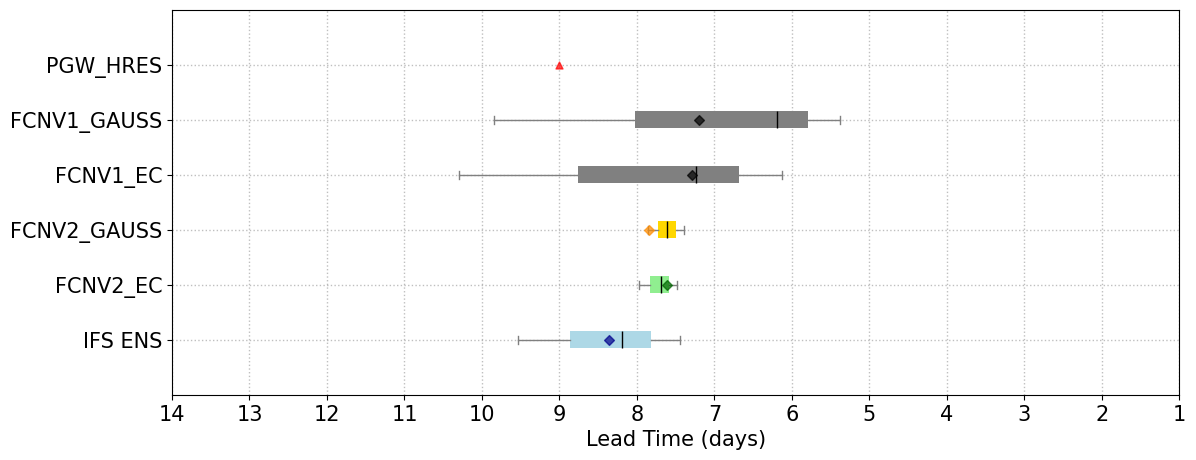

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era, lt_z500_fcnv1_ec, lt_z500_fcnv1_era, lt_z500_pangu)

fig, ax = plt.subplots(figsize=(13, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold', 'grey', 'grey']
box_positions = [0, 0.5, 1, 1.5, 2]  # Adjust these positions as needed
box_labels = ['IFS ENS', 'FCNV2_EC', 'FCNV2_GAUSS', 'FCNV1_EC', 'FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era, lt_z500_fcnv1_ec, lt_z500_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey', linewidth=1)
    cap_properties = dict(color='grey', linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')

    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops=whisker_properties, capprops=cap_properties, showfliers=True, patch_artist=True, medianprops=dict(color='black'), flierprops=outlier_properties)

# Plot the scatter points
points_1 = ax.scatter(lt_z500_ec_cf, box_positions[0], color='darkblue', marker='D', zorder=5, s=25, alpha=0.7)
points_2 = ax.scatter(lt_z500_fcnv2_ec_cf, box_positions[1], color='darkgreen', marker='D', zorder=5, s=25, alpha=0.7)
points_3 = ax.scatter(lt_z500_fcnv2_era_cf, box_positions[2], color='darkorange', marker='D', zorder=5, s=25, alpha=0.7)
points_4 = ax.scatter(lt_z500_fcnv1_ec_cf, box_positions[3], color='black', marker='D', zorder=5, s=25, alpha=0.7)
points_5 = ax.scatter(lt_z500_fcnv1_era_cf, box_positions[4], color='black', marker='D', zorder=5, s=25, alpha=0.7)

# Position the sixth point on a new row
new_row_position = max(box_positions) + 0.5  # Position it below the last box
points_6 = ax.scatter(lt_z500_pangu, new_row_position, color='red', marker='^', zorder=5, s=25, alpha=0.7)

# Annotate the specific point (points_6)
#label = 'PGW_HRES'  # Replace with your actual label
#x = lt_z500_pangu + 0.4
#y = new_row_position + 0.2
#ax.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha='left', color='red')

# Set the x-axis label
ax.set_xlabel('Lead Time (days)')

# Add the new label for the y-axis
all_labels = box_labels + ['PGW_HRES']
plt.yticks(box_positions + [new_row_position], all_labels)

plt.xticks(np.arange(1, 15, 1))
plt.gca().invert_xaxis()
plt.xlim(14, 1)

plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)

# Adjust y-axis limits to accommodate the new row
plt.ylim(-0.5, new_row_position + 0.5)

# Save the figure
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_forecast_horizon_z500.png', bbox_inches='tight', dpi=100)

# Display the plot
plt.show()

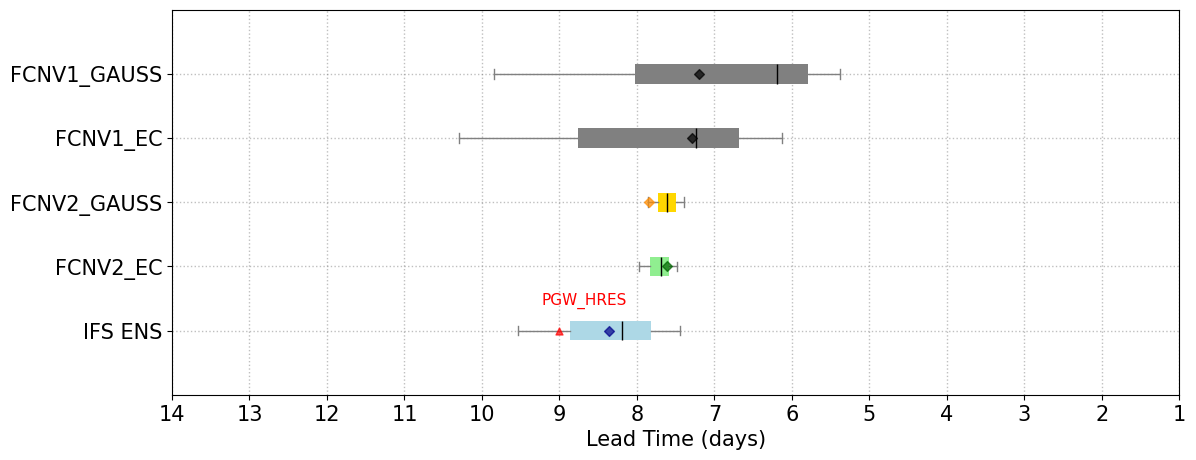

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(13, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1,1.5,2,2.5]  # Adjust these positions as needed
box_labels = ['IFS ENS', 'FCNV2_EC', 'FCNV2_GAUSS', 'FCNV1_EC', 'FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era, lt_z500_fcnv1_ec, lt_z500_fcnv1_era], box_colors, box_positions)):
        box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
        whisker_properties = dict(color='grey', linewidth=1)
        cap_properties = dict(color='grey', linewidth=1)
        outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
        
        # Use position to set the specific y-axis position for each boxplot
        plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                    vert=False, boxprops=box_properties, whiskerprops=whisker_properties, capprops=cap_properties, showfliers=True, patch_artist=True, medianprops=dict(color='black'), flierprops=outlier_properties)

# Plot the scatter points
points_1 = ax.scatter(lt_z500_ec_cf, box_positions[0], color='darkblue', marker='D', zorder=5, s=25, alpha=0.7)
points_2 = ax.scatter(lt_z500_fcnv2_ec_cf, box_positions[1], color='darkgreen', marker='D', zorder=5, s=25, alpha=0.7)
points_3 = ax.scatter(lt_z500_fcnv2_era_cf, box_positions[2], color='darkorange', marker='D', zorder=5, s=25, alpha=0.7)
points_4 = ax.scatter(lt_z500_fcnv1_ec_cf, box_positions[3], color='black', marker='D', zorder=5, s=25, alpha=0.7)
points_5 = ax.scatter(lt_z500_fcnv1_era_cf, box_positions[4], color='black', marker='D', zorder=5, s=25, alpha=0.7)
points_6 = ax.scatter(lt_z500_pangu , box_positions[0], color='red', marker='^', zorder=5, s=25, alpha=0.7)

# Annotate the specific point (points_6)
label = 'PGW_HRES'  # Replace with your actual label
x = lt_z500_pangu +0.4
y = box_positions[0]+0.2
ax.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha='left', color='red')

# Set the x-axis label
ax.set_xlabel('Lead Time (days)')
plt.xticks(np.arange(1, 15, 1))
plt.gca().invert_xaxis()
plt.xlim(14, 1)

#ax.set_xticks( [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.savefig('/home/kit/imktro/gj5173/08_06_plots/final_forecast_horizon_z500.png', bbox_inches='tight',dpi=100)
plt.show()

In [ ]:
points_1 = ax.scatter(lt_z500_ec_cf, box_positions[0], color='darkblue', marker='D', zorder=5, s=25, alpha=0.7)
points_2 = ax.scatter(lt_z500_fcnv2_ec_cf, box_positions[1], color='darkgreen', marker='D', zorder=5, s=25, alpha=0.7)
points_3 = ax.scatter(lt_z500_fcnv2_era_cf, box_positions[2], color='darkorange', marker='D', zorder=5, s=25, alpha=0.7)
points_4 = ax.scatter(lt_z500_fcnv1_ec_cf, box_positions[3], color='black', marker='D', zorder=5, s=25, alpha=0.7)
points_5 = ax.scatter(lt_z500_fcnv1_era_cf, box_positions[4], color='black', marker='D', zorder=5, s=25, alpha=0.7)

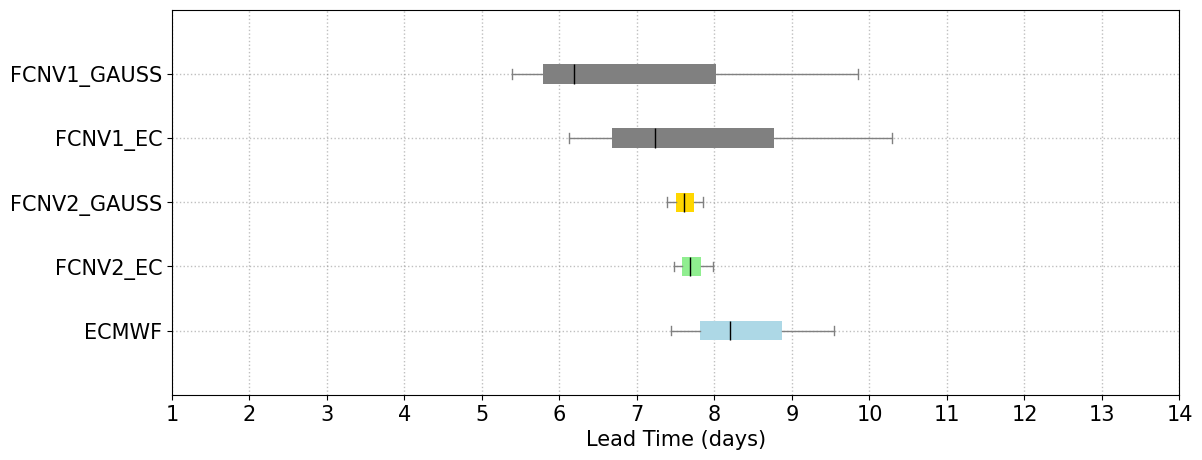

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(13, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC','FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era,lt_z500_fcnv1_ec, lt_z500_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='black'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks([14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#tick_labels = [str(i) for i in range(14, 0, -1)]
#plt.gca().set_xticks(range(1, len(tick_labels) + 1))
#plt.gca().set_xticklabels(tick_labels)
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
#plt.savefig('/home/kit/imk-tro/gj5173/result1/leadtime_gain_z500_06_v1v2.png', bbox_inches='tight',dpi=100)

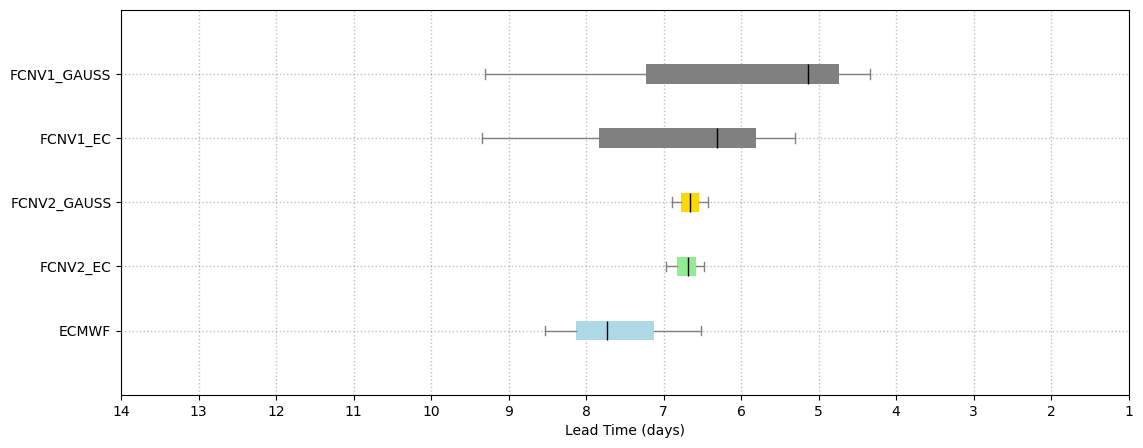

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(13, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC','FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era,lt_z500_fcnv1_ec, lt_z500_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='black'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#tick_labels = [str(i) for i in range(14, 0, -1)]
#plt.gca().set_xticks(range(1, len(tick_labels) + 1))
#plt.gca().set_xticklabels(tick_labels)
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
plt.savefig('/home/kit/imk-tro/gj5173/result1/leadtime_gain_z500_06_v1v2.png', bbox_inches='tight',dpi=100)

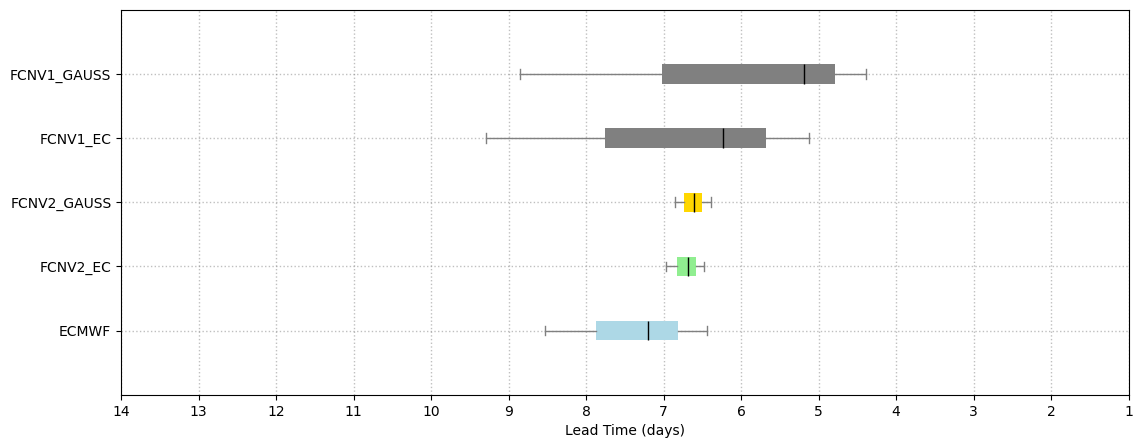

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(13, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold','grey','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC','FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era,lt_z500_fcnv1_ec, lt_z500_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='black'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#tick_labels = [str(i) for i in range(14, 0, -1)]
#plt.gca().set_xticks(range(1, len(tick_labels) + 1))
#plt.gca().set_xticklabels(tick_labels)
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
plt.savefig('/home/kit/imk-tro/gj5173/result1/leadtime_gain_z500_06_v1v2_mean.png', bbox_inches='tight',dpi=100)

In [ ]:
###################################  panel plot ######################################################################

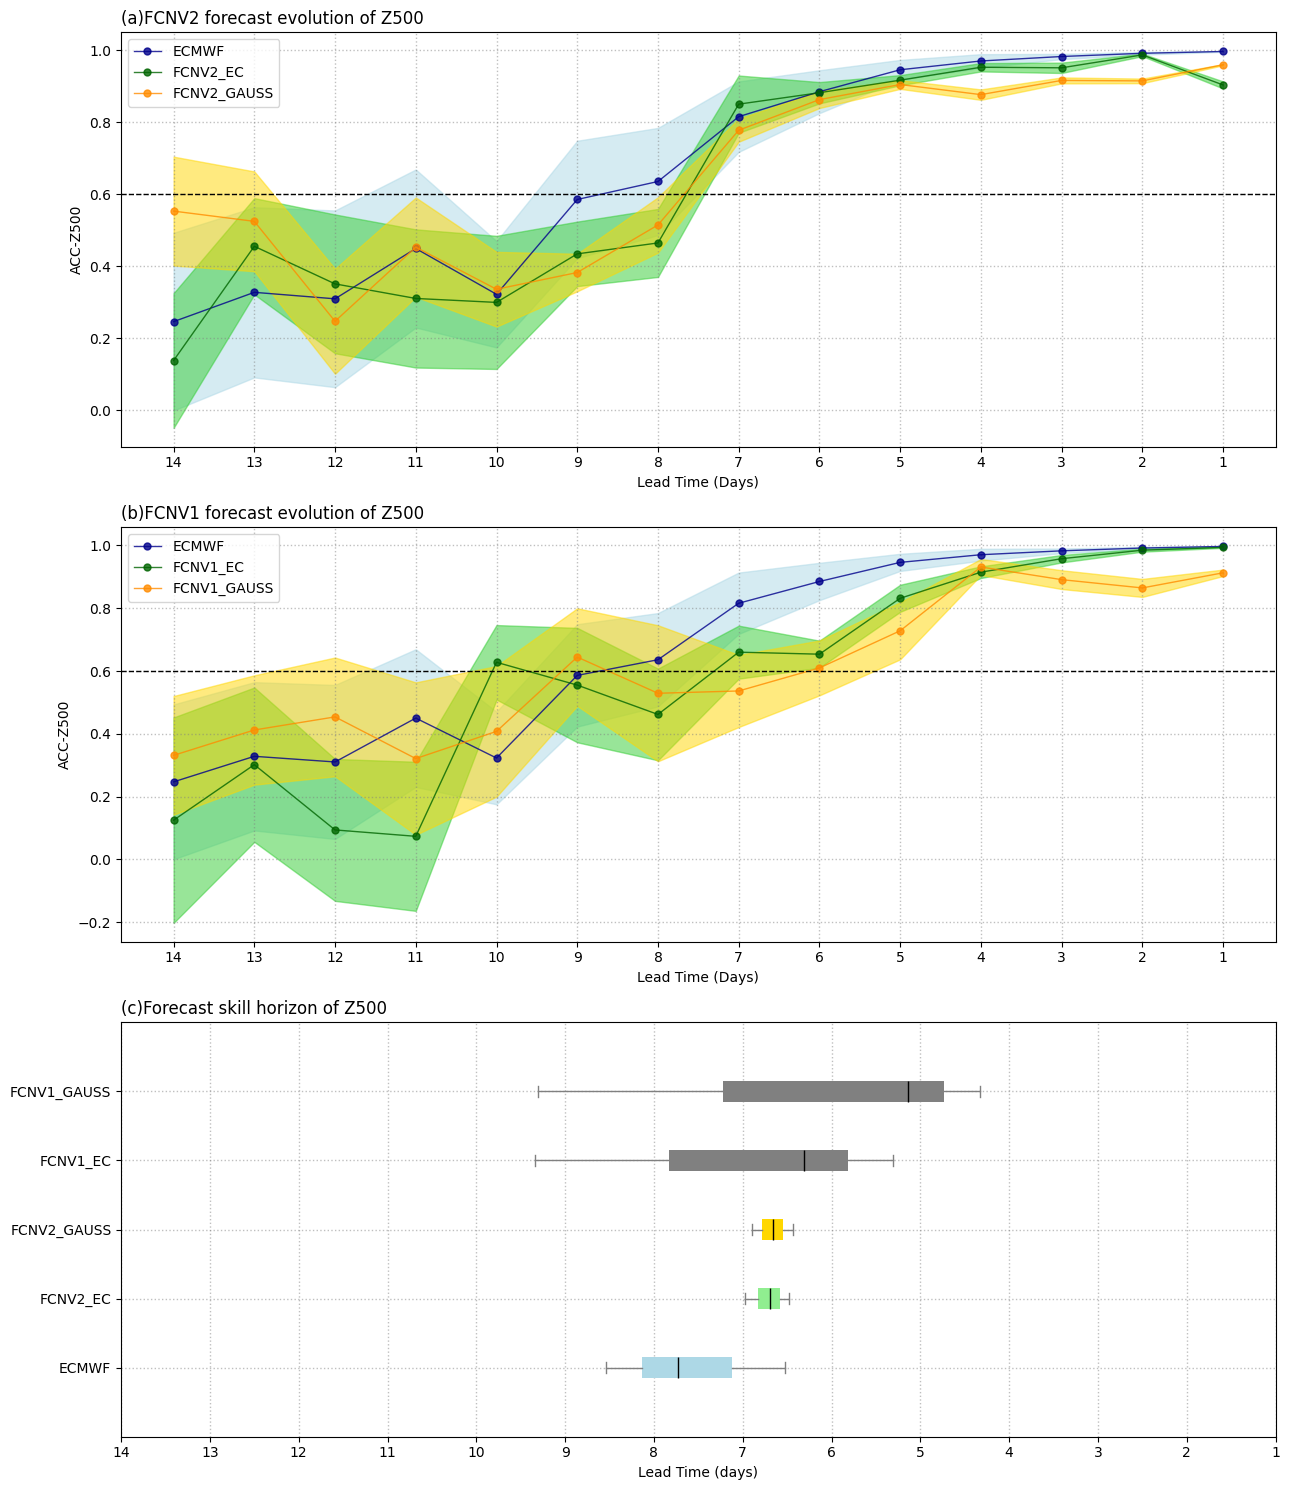

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Data and plotting for the first plot
fig, axs = plt.subplots(3, 1, figsize=(13, 15))  # 1 row, 3 columns
axs[0].plot(x, ds_median_ec_ens_box_weighted, marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
axs[0].fill_between(x, ds_median_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_median_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
axs[0].plot(x, ds_median_fcnv2_ec_ens_box_weighted[:], marker='o', label='FCNV2_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
axs[0].fill_between(x, ds_median_fcnv2_ec_ens_box_weighted - ds_std_dev_fcnv2_ec_ens_box_weighted, ds_median_fcnv2_ec_ens_box_weighted + ds_std_dev_fcnv2_ec_ens_box_weighted, color='limegreen', alpha=0.5)
axs[0].plot(x, ds_median_fcnv2_era_ens_box_weighted[:], marker='o', label='FCNV2_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
axs[0].fill_between(x, ds_median_fcnv2_era_ens_box_weighted - ds_std_dev_fcnv2_era_ens_box_weighted, ds_median_fcnv2_era_ens_box_weighted + ds_std_dev_fcnv2_era_ens_box_weighted, color='gold', alpha=0.5)
axs[0].axhline(threshold_ACC, color='black', linestyle='--', linewidth=1)
axs[0].set_xticks(x)
axs[0].set_xticklabels([str(i) for i in reversed(range(1, 15))])
axs[0].grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
axs[0].set_ylabel('ACC-Z500')
axs[0].set_xlabel('Lead Time (Days)')
axs[0].set_title('(a)FCNV2 forecast evolution of Z500',loc='left')
axs[0].legend()

# Data and plotting for the second plot
axs[1].plot(x, ds_median_ec_ens_box_weighted, marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
axs[1].fill_between(x, ds_median_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_median_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
axs[1].plot(x, ds_median_fcnv1_ec_ens_box_weighted[:], marker='o', label='FCNV1_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
axs[1].fill_between(x, ds_median_fcnv1_ec_ens_box_weighted - ds_std_dev_fcnv1_ec_ens_box_weighted, ds_median_fcnv1_ec_ens_box_weighted + ds_std_dev_fcnv1_ec_ens_box_weighted, color='limegreen', alpha=0.5)
axs[1].plot(x, ds_median_fcnv1_era_ens_box_weighted[:], marker='o', label='FCNV1_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
axs[1].fill_between(x, ds_median_fcnv1_era_ens_box_weighted - ds_std_dev_fcnv1_era_ens_box_weighted, ds_median_fcnv1_era_ens_box_weighted + ds_std_dev_fcnv1_era_ens_box_weighted, color='gold', alpha=0.5)
axs[1].axhline(threshold_ACC, color='black', linestyle='--', linewidth=1)
axs[1].set_xticks(x)
axs[1].set_xticklabels([str(i) for i in reversed(range(1, 15))])
axs[1].grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
axs[1].set_ylabel('ACC-Z500')
axs[1].set_xlabel('Lead Time (Days)')
axs[1].set_title('(b)FCNV1 forecast evolution of Z500',loc='left')
axs[1].legend()

# Data and plotting for the third plot
box_colors = ['lightblue', 'lightgreen', 'gold', 'grey', 'grey']
box_positions = [0, 0.5, 1, 1.5, 2]
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS', 'FCNV1_EC', 'FCNV1_GAUSS']

for i, (data, color, position) in enumerate(zip([lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era, lt_z500_fcnv1_ec, lt_z500_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey', linewidth=1)
    cap_properties = dict(color='grey', linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    
    axs[2].boxplot(data, positions=[position], labels=[box_labels[i]], vert=False, boxprops=box_properties, whiskerprops=whisker_properties, capprops=cap_properties, showfliers=True, patch_artist=True, medianprops=dict(color='black'), flierprops=outlier_properties)

axs[2].set_xlabel('Lead Time (days)')
axs[2].set_xticks(x)
axs[2].set_xticklabels([str(i) for i in reversed(range(1, 15))])
axs[2].grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
axs[2].set_title('(c)Forecast skill horizon of Z500',loc='left')
plt.tight_layout()
plt.savefig('/home/kit/imk-tro/gj5173/result1/forecast_skill_v1v2_z500*3.png', bbox_inches='tight',dpi=100)

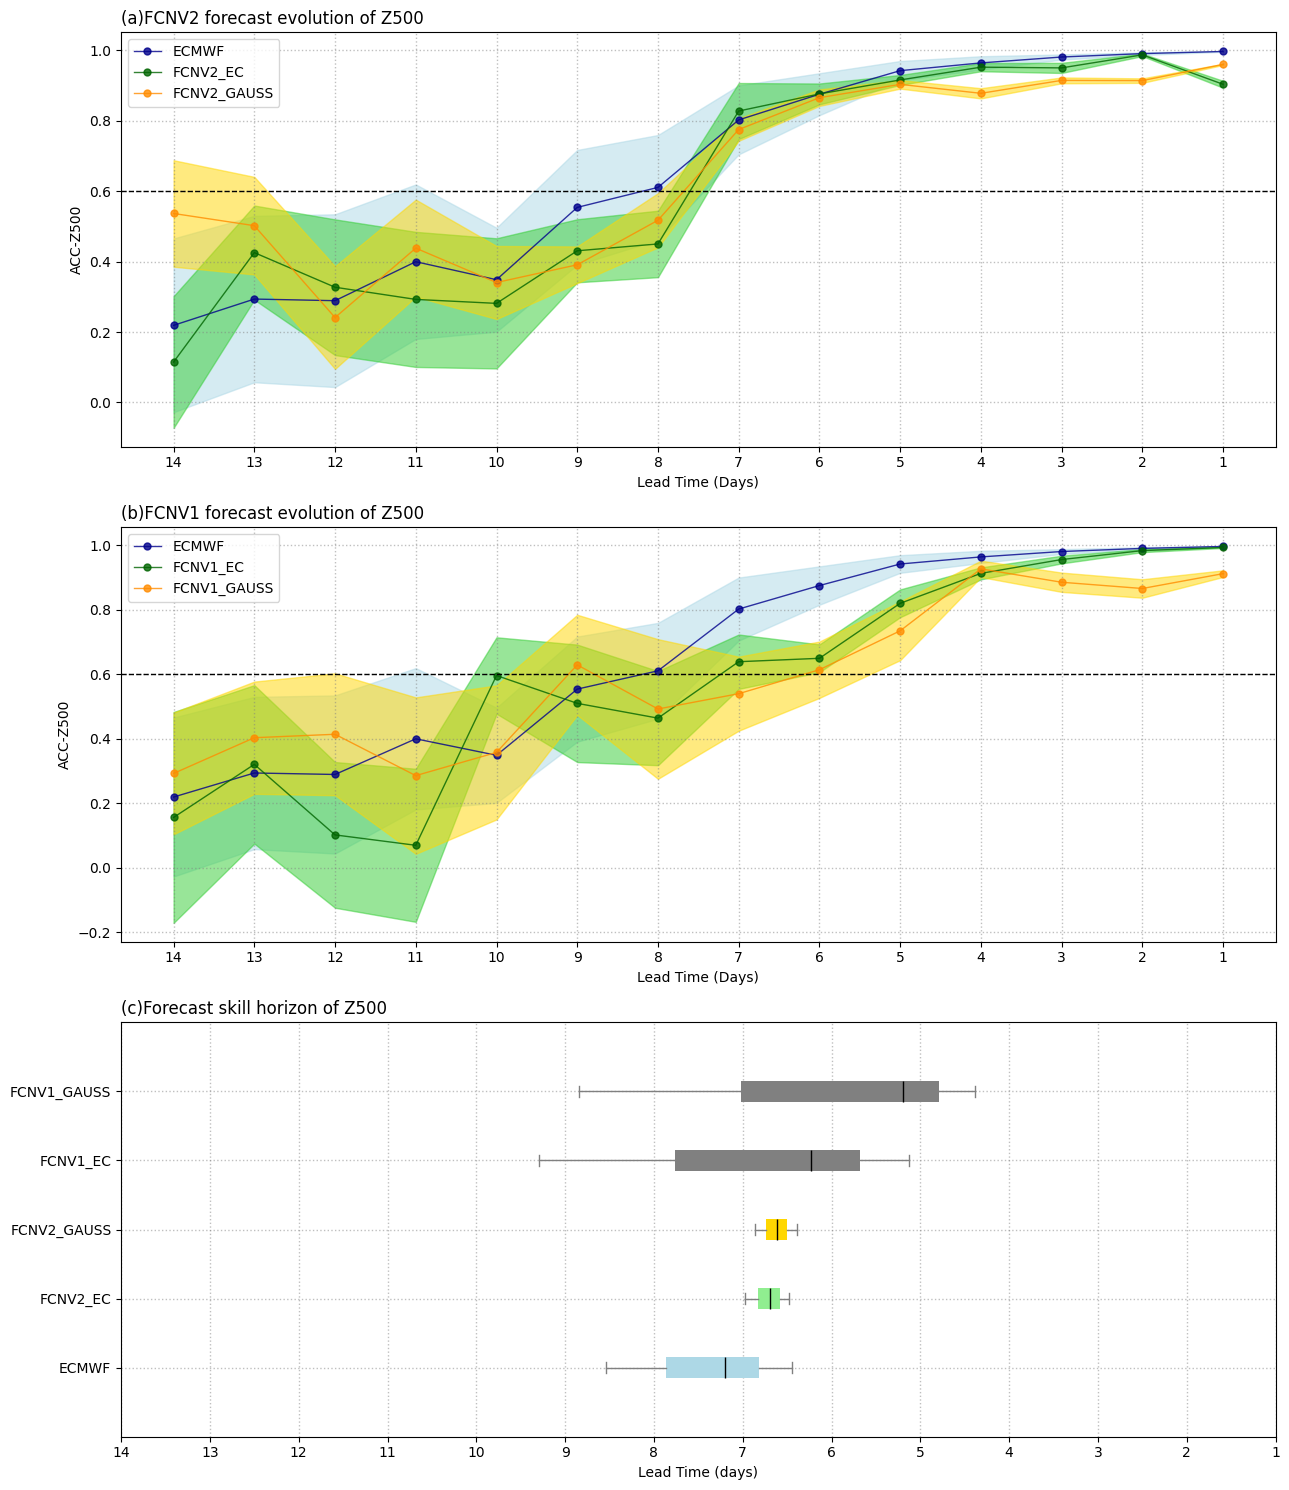

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data and plotting for the first plot
fig, axs = plt.subplots(3, 1, figsize=(13, 15))  # 1 row, 3 columns
axs[0].plot(x, ds_mean_ec_ens_box_weighted, marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
axs[0].fill_between(x, ds_mean_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_mean_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
axs[0].plot(x, ds_mean_fcnv2_ec_ens_box_weighted[:], marker='o', label='FCNV2_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
axs[0].fill_between(x, ds_mean_fcnv2_ec_ens_box_weighted - ds_std_dev_fcnv2_ec_ens_box_weighted, ds_mean_fcnv2_ec_ens_box_weighted + ds_std_dev_fcnv2_ec_ens_box_weighted, color='limegreen', alpha=0.5)
axs[0].plot(x, ds_mean_fcnv2_era_ens_box_weighted[:], marker='o', label='FCNV2_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
axs[0].fill_between(x, ds_mean_fcnv2_era_ens_box_weighted - ds_std_dev_fcnv2_era_ens_box_weighted, ds_mean_fcnv2_era_ens_box_weighted + ds_std_dev_fcnv2_era_ens_box_weighted, color='gold', alpha=0.5)
axs[0].axhline(threshold_ACC, color='black', linestyle='--', linewidth=1)
axs[0].set_xticks(x)
axs[0].set_xticklabels([str(i) for i in reversed(range(1, 15))])
axs[0].grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
axs[0].set_ylabel('ACC-Z500')
axs[0].set_xlabel('Lead Time (Days)')
axs[0].set_title('(a)FCNV2 forecast evolution of Z500',loc='left')
axs[0].legend()

# Data and plotting for the second plot
axs[1].plot(x, ds_mean_ec_ens_box_weighted, marker='o', label='ECMWF', linewidth=1, markersize=5, color='darkblue', alpha=0.8)
axs[1].fill_between(x, ds_mean_ec_ens_box_weighted - ds_std_dev_ec_ens_box_weighted, ds_mean_ec_ens_box_weighted + ds_std_dev_ec_ens_box_weighted, color='lightblue', alpha=0.5)
axs[1].plot(x, ds_mean_fcnv1_ec_ens_box_weighted[:], marker='o', label='FCNV1_EC', linewidth=1, markersize=5, color='darkgreen', alpha=0.8)
axs[1].fill_between(x, ds_mean_fcnv1_ec_ens_box_weighted - ds_std_dev_fcnv1_ec_ens_box_weighted, ds_mean_fcnv1_ec_ens_box_weighted + ds_std_dev_fcnv1_ec_ens_box_weighted, color='limegreen', alpha=0.5)
axs[1].plot(x, ds_mean_fcnv1_era_ens_box_weighted[:], marker='o', label='FCNV1_GAUSS', linewidth=1, markersize=5, color='darkorange', alpha=0.8)
axs[1].fill_between(x, ds_mean_fcnv1_era_ens_box_weighted - ds_std_dev_fcnv1_era_ens_box_weighted, ds_mean_fcnv1_era_ens_box_weighted + ds_std_dev_fcnv1_era_ens_box_weighted, color='gold', alpha=0.5)
axs[1].axhline(threshold_ACC, color='black', linestyle='--', linewidth=1)
axs[1].set_xticks(x)
axs[1].set_xticklabels([str(i) for i in reversed(range(1, 15))])
axs[1].grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
axs[1].set_ylabel('ACC-Z500')
axs[1].set_xlabel('Lead Time (Days)')
axs[1].set_title('(b)FCNV1 forecast evolution of Z500',loc='left')
axs[1].legend()

# Data and plotting for the third plot
box_colors = ['lightblue', 'lightgreen', 'gold', 'grey', 'grey']
box_positions = [0, 0.5, 1, 1.5, 2]
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS', 'FCNV1_EC', 'FCNV1_GAUSS']

for i, (data, color, position) in enumerate(zip([lt_z500_ec, lt_z500_fcnv2_ec, lt_z500_fcnv2_era, lt_z500_fcnv1_ec, lt_z500_fcnv1_era], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey', linewidth=1)
    cap_properties = dict(color='grey', linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    
    axs[2].boxplot(data, positions=[position], labels=[box_labels[i]], vert=False, boxprops=box_properties, whiskerprops=whisker_properties, capprops=cap_properties, showfliers=True, patch_artist=True, medianprops=dict(color='black'), flierprops=outlier_properties)

axs[2].set_xlabel('Lead Time (days)')
axs[2].set_xticks(x)
axs[2].set_xticklabels([str(i) for i in reversed(range(1, 15))])
axs[2].grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
axs[2].set_title('(c)Forecast skill horizon of Z500',loc='left')
plt.tight_layout()
plt.savefig('/home/kit/imk-tro/gj5173/result1/forecast_skill_v1v2_z500*3_mean.png', bbox_inches='tight',dpi=100)

In [ ]:
##################################### only took the lead time of median when it first across the 0.6  line ########################################################################

In [8]:
from scipy.interpolate import interp1d
lead_time = np.linspace(14, 1, 14)
fine_lead_times = np.linspace(14, 1, 1000)
interp_func_ec = interp1d(lead_time, ds_median_ec_ens_box, kind='linear')
interp_func_fcnv2_ec = interp1d(lead_time, ds_median_fcnv2_ec_ens_box, kind='linear')
interp_func_fcnv2_era = interp1d(lead_time, ds_median_fcnv2_era_ens_box, kind='linear')
# Interpolate the median data at the finer grid of lead times
interpolated_median_data_ec = interp_func_ec(fine_lead_times)
interpolated_median_data_fcnv2_ec = interp_func_fcnv2_ec(fine_lead_times)
interpolated_median_data_fcnv2_era = interp_func_fcnv2_era(fine_lead_times)
# Find the first lead time when the interpolated median exceeds 0.6
lead_time_index_ec = np.argmax(interpolated_median_data_ec > 0.6)
lead_time_index_fcnv2_ec = np.argmax(interpolated_median_data_fcnv2_ec > 0.6)
lead_time_index_fcnv2_era = np.argmax(interpolated_median_data_fcnv2_era > 0.6)
# Extract the lead time
lead_time_ec = fine_lead_times[lead_time_index_ec]
lead_time_fcnv2_ec = fine_lead_times[lead_time_index_fcnv2_ec]
lead_time_fcnv2_era = fine_lead_times[lead_time_index_fcnv2_era]

In [12]:
lead_time_ec

8.885885885885886

In [13]:
lead_time_fcnv2_ec 

7.506506506506507

In [14]:
lead_time_fcnv2_era

7.584584584584585

In [ ]:
############################ overlay the cf on ############################################################################

In [30]:
acc_fcnv2_era_z500_0629_big[0:14]
acc_fcnv2_ec_z500_0629_big[0:14]

array([-0.01472087,  0.43627722,  0.71374952,  0.33381467,  0.58308129,
        0.1770807 ,  0.52766066,  0.42341642,  0.88726119,  0.84394514,
        0.90680157,  0.93372696,  0.95202082,  0.99176485])

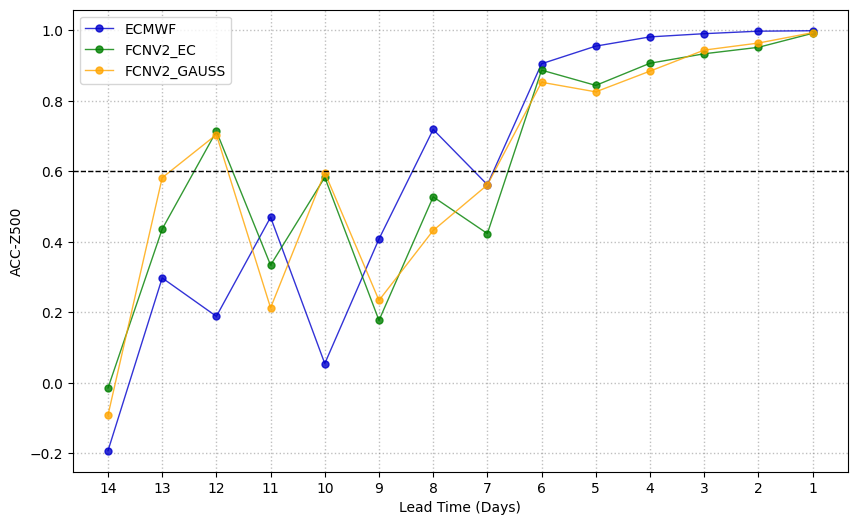

In [35]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

x = np.linspace(0, 13, 14)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, acc_ec_z500_big_0629[0:14] ,marker='o',label='ECMWF',linewidth=1,markersize= 5,color = 'mediumblue',alpha=0.8);

ax.plot(x, acc_fcnv2_ec_z500_0629_big[0:14],marker='o',label='FCNV2_EC',linewidth=1,markersize= 5,color = 'green',alpha=0.8);

ax.plot(x, acc_fcnv2_era_z500_0629_big[0:14],marker='o',label='FCNV2_GAUSS',linewidth=1,markersize= 5,color = 'orange',alpha=0.8);
#ax.plot(x, acc_fcnv1_ec_z500_big_0629,marker='o',label='FCN_EC_CF',color = 'limegreen');
#ax.scatter(x, acc_ec_z500_big_0629,marker='o',label='ECMWF_CF',linewidth=1,color = 'mediumblue');
#ax.scatter(x, acc_fcnv1_era_z500_big_0629,marker='o',label='FCN_ERA_CF',color='darkorange');
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
#plt.savefig('/home/kit/imk-tro/gj5173/02.29_REPORT/line_plot_0629_z500_ACC_FCNV2.png', bbox_inches='tight',dpi=100)

In [ ]:
################################################## lead time gain ##############################################################################################################

In [ ]:
ds_mean_ec_ens_box, ds_median_ec_ens_box, ds_std_dev_ec_ens_box = calculate_stats_as_xarray(acc_ec_z500_big_0629_ens[0:14,:])

ds_mean_fcnv1_ec_ens_box, ds_median_fcnv1_ec_ens_box, ds_std_dev_fcnv1_ec_ens_box = calculate_stats_as_xarray(acc_fcnv1_ec_z500_big_0629_ens[0:14,:])

ds_mean_fcnv1_era_ens_box, ds_median_fcnv1_era_ens_box, ds_std_dev_fcnv1_era_ens_box = calculate_stats_as_xarray(acc_fcnv1_era_z500_big_0629_ens[0:14,:])

ds_mean_fcnv2_ec_ens_box, ds_median_fcnv2_ec_ens_box, ds_std_dev_fcnv2_ec_ens_box = calculate_stats_as_xarray(acc_fcnv2_ec_z500_0629_ens_big)

ds_mean_fcnv2_era_ens_box, ds_median_fcnv2_era_ens_box, ds_std_dev_fcnv2_era_ens_box = calculate_stats_as_xarray(acc_fcnv2_era_z500_0629_ens_big)

In [ ]:
acc_ec_z500_big_0629_ens

In [ ]:
acc_fcnv1_ec_z500_big_0629_ens

In [ ]:
acc_fcnv1_era_z500_big_0629_ens

In [ ]:
acc_fcnv2_era_z500_0629_ens_big

In [ ]:
acc_fcnv2_ec_z500_0629_ens_big

In [25]:
acc_fcnv1_ec_z500_big_0629_ens[14,:] = acc_ec_z500_big_0629_ens[14,:]

In [26]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf_large=[]
for i in range(50):
    data = acc_ec_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 100)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_ec_pf_large.append(x_value)

In [27]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_fcn_ec_pf_large=[]
for i in range(50):
    data = acc_fcnv2_ec_z500_0629_ens_big[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 100)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data< 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fcn_ec_pf_large.append(x_value)

In [28]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_fcn_era_pf_large=[]
for i in range(50):
    data = acc_fcnv2_era_z500_0629_ens_big[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 100)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data <0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fcn_era_pf_large.append(x_value)

In [29]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_fcnv1_ec_pf_large=[]
for i in range(50):
    data = acc_fcnv1_ec_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 100)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data< 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fcnv1_ec_pf_large.append(x_value)

In [30]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_fcnv1_era_pf_large=[]
for i in range(50):
    data = acc_fcnv1_era_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 100)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data <0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fcnv1_era_pf_large.append(x_value)

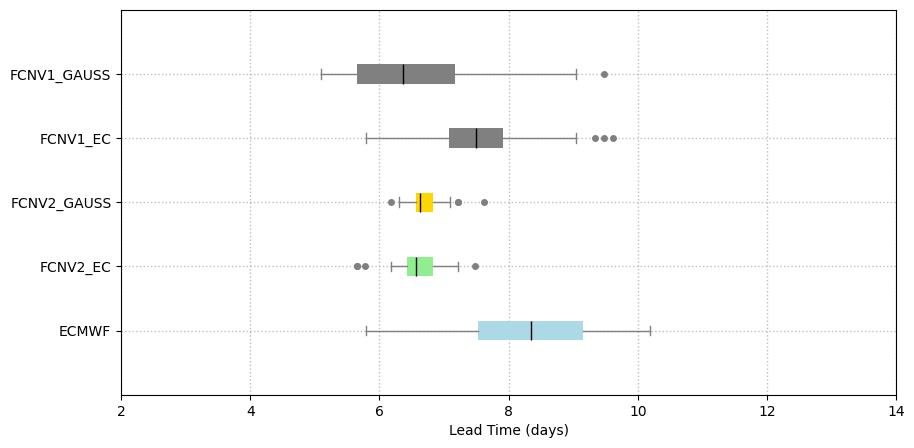

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(10, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold','gray','grey']
box_positions = [0,0.5,1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV2_EC', 'FCNV2_GAUSS','FCNV1_EC', 'FCNV1_GAUSS']  # Make sure the length matches the number of boxes

# Use enumerate to iterate over both the index and the color
for i, (data, color, position) in enumerate(zip([ lt_gain_ec_pf_large,  lt_gain_fcn_ec_pf_large,  lt_gain_fcn_era_pf_large,lt_gain_fcnv1_ec_pf_large,lt_gain_fcnv1_era_pf_large], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='black'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks([2,4,6,8,10,12,14])
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
plt.savefig('/home/kit/imk-tro/gj5173/02.29_REPORT/leadtime_gain_ACC_Z500_v1v2.png', bbox_inches='tight',dpi=100)
plt.show()

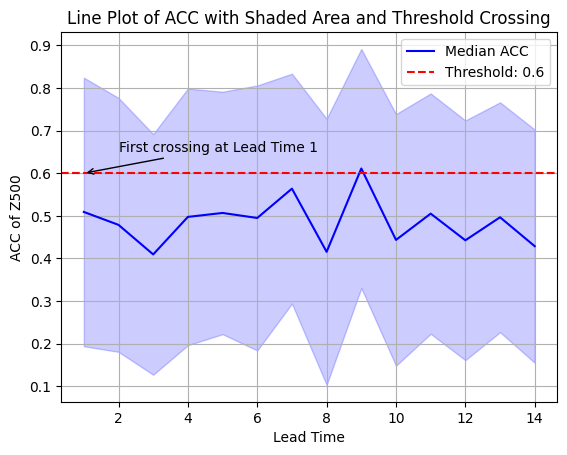

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)
lead_times = np.arange(1, 15)
ACC_data = np.random.rand(50, 14)  # Example ACC data for 50 ensemble members

# Calculate median and standard deviation across ensemble members for each lead time
median_ACC = np.median(ACC_data, axis=0)
std_ACC = np.std(ACC_data, axis=0)

# Plot solid line for median and shaded area for +/- 1 std
plt.plot(lead_times, median_ACC, color='blue', label='Median ACC')
plt.fill_between(lead_times, median_ACC - std_ACC, median_ACC + std_ACC, color='blue', alpha=0.2)

# Set the threshold
threshold = 0.6

# Identify lead time when ACC first crosses threshold
lead_time_threshold_crossed = None
for lead_time, acc_values in zip(lead_times, ACC_data.T):
    if any(acc >= threshold for acc in acc_values):
        lead_time_threshold_crossed = lead_time
        break

# Plot the threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')

# Annotate the plot with the lead time when threshold is crossed
if lead_time_threshold_crossed is not None:
    plt.annotate(f'First crossing at Lead Time {lead_time_threshold_crossed}', 
                 xy=(lead_time_threshold_crossed, threshold),
                 xytext=(lead_time_threshold_crossed + 1, threshold + 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

# Set labels and title
plt.xlabel('Lead Time')
plt.ylabel('ACC of Z500')
plt.title('Line Plot of ACC with Shaded Area and Threshold Crossing')
plt.legend()
plt.grid(True)
plt.show()


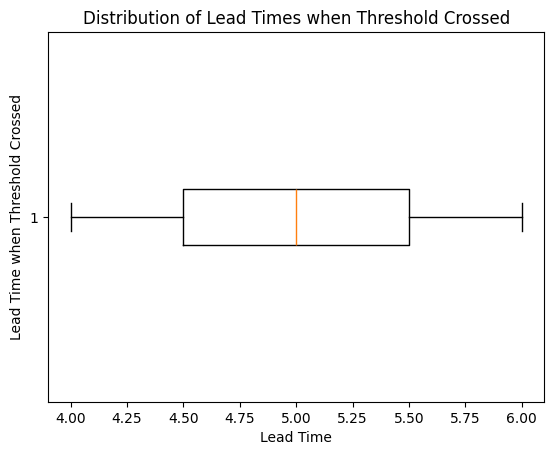

In [18]:
import matplotlib.pyplot as plt

# Example lead time values (replace these with your extracted lead time values)
lead_times_median_crossed = 5
lead_times_upper_std_crossed = 6
lead_times_lower_std_crossed = 4

# Create a list of lead time values
lead_times = [lead_times_median_crossed, lead_times_upper_std_crossed, lead_times_lower_std_crossed]

# Create a box plot using the lead time values
plt.figure()
plt.boxplot(lead_times, vert=False)
plt.xlabel('Lead Time')
plt.ylabel('Lead Time when Threshold Crossed')
plt.title('Distribution of Lead Times when Threshold Crossed')
plt.show()